### Baseline Text Data Augmentation Methods

Compare and supplement advanced method with baseline traditional (easy to implement methods).


### Prepare Environment

In [1]:
import random
from numpy.random import seed
from random import shuffle
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
seed(156)

In [22]:
#import sys
#print(sys.version)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [4]:
# Install required nltk resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Importing required libraries
import pandas as pd
from tqdm.std import tqdm
from IPython.display import display, HTML
from nltk.corpus import wordnet
import time
import re

### Load Data

In [7]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]

sample_name = f'df_train_trues_{focus_cat}' 
reports = pd.read_csv(f"01_data/prepared/{sample_name}.csv", dtype=str)  
reports

Pick a category: line strike


,Unnamed: 0,text,category
0,285,dc cable struck allied fencing employees repor...,1
1,791,it was notice that part of the bank had collap...,1
2,819,plate compactor was damaged when operator turn...,1
3,824,excavator made contact with two empty one inch...,1
4,1252,as the equipment operator began to dig into th...,1
...,...,...,...
256,86830,contact with hot objects or substances a contr...,1
257,89205,direct exposure to electricity greater than tw...,1
258,91291,indirect exposure to electricity unspecified a...,1
259,92988,direct exposure to electricity unspecified emp...,1


In [8]:
# Remove unecessary columns.
reports = reports[['text', 'category']]
reports

,text,category
0,dc cable struck allied fencing employees repor...,1
1,it was notice that part of the bank had collap...,1
2,plate compactor was damaged when operator turn...,1
3,excavator made contact with two empty one inch...,1
4,as the equipment operator began to dig into th...,1
...,...,...
256,contact with hot objects or substances a contr...,1
257,direct exposure to electricity greater than tw...,1
258,indirect exposure to electricity unspecified a...,1
259,direct exposure to electricity unspecified emp...,1


### Simple Text Augmentation Techniques

Jason W Wei and Kai Zou. 2019. Eda: Easy data augmentation techniques for boosting perfor- mance on text classification tasks. arXiv preprint arXiv:1901.11196.

- Synonym Replacement (SR)
- Random Deletion (RD)
- Random Swap (RS)
- Random Insertion (RI)

In [9]:
# Modifications Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: CC-BY-NC-4.0
# Original Copyright https://github.com/jasonwei20/eda_nlp

# stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our',
              'ours', 'ourselves', 'you', 'your', 'yours',
              'yourself', 'yourselves', 'he', 'him', 'his',
              'himself', 'she', 'her', 'hers', 'herself',
              'it', 'its', 'itself', 'they', 'them', 'their',
              'theirs', 'themselves', 'what', 'which', 'who',
              'whom', 'this', 'that', 'these', 'those', 'am',
              'is', 'are', 'was', 'were', 'be', 'been', 'being',
              'have', 'has', 'had', 'having', 'do', 'does', 'did',
              'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
              'because', 'as', 'until', 'while', 'of', 'at',
              'by', 'for', 'with', 'about', 'against', 'between',
              'into', 'through', 'during', 'before', 'after',
              'above', 'below', 'to', 'from', 'up', 'down', 'in',
              'out', 'on', 'off', 'over', 'under', 'again',
              'further', 'then', 'once', 'here', 'there', 'when',
              'where', 'why', 'how', 'all', 'any', 'both', 'each',
              'few', 'more', 'most', 'other', 'some', 'such', 'no',
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too',
              'very', 's', 't', 'can', 'will', 'just', 'don',
              'should', 'now', '']

def get_only_chars(line):
    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ")  # replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +', ' ', clean_line)  # delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line



# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            # print("replaced", random_word, "with", synonym)
            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return new_words


def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)



# Random deletion
# Randomly delete words from the sentence with probability p
def random_deletion(words, p):
    # obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    # randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    # if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words) - 1)
        return [words[rand_int]]

    return new_words


# Random swap
# Randomly swap two words in the sentence n times
def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words


def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words) - 1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words) - 1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words


# Random insertion
# Randomly insert n words into the sentence
def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words


def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words) - 1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words) - 1)
    new_words.insert(random_idx, random_synonym)



# main data augmentation function
def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
    sentence = get_only_chars(sentence)
    words = sentence.split(' ')
    words = [word for word in words if word is not '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug / 4) + 1
    n_sr = max(1, int(alpha_sr * num_words))
    n_ri = max(1, int(alpha_ri * num_words))
    n_rs = max(1, int(alpha_rs * num_words))

    # synonym replacement
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    # random insertion
    for _ in range(num_new_per_technique):
        a_words = random_insertion(words, n_ri)
        augmented_sentences.append(' '.join(a_words))

    # randown swap
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(' '.join(a_words))

    # random deletion
    for _ in range(num_new_per_technique):
        a_words = random_deletion(words, p_rd)
        augmented_sentences.append(' '.join(a_words))

    augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
    shuffle(augmented_sentences)

    # trim so that we have the desired number of augmented sentences
    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

    return augmented_sentences

<>:159: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:159: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-9-35b384337ca4>:159: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  words = [word for word in words if word is not '']


In [10]:
random.uniform(0, 1)

0.47197138041718234

In [11]:
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            print("replaced", random_word, "with", synonym)
            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return new_words

In [12]:
def gen_eda(in_df, alpha, num_aug=1):

    #in_df.reset_index(inplace=True)
    lines = in_df.text
    labels = in_df.category
    out_sens = []
    
    for i, line in tqdm(enumerate(lines)):        
        label = int(labels[i])
        if label == 1:
            sentence = line
            aug_sentence = eda(sentence, alpha_sr=alpha, alpha_ri=alpha, alpha_rs=alpha, p_rd=alpha, num_aug=num_aug)
            out_sens.extend(aug_sentence)

    out_df = pd.DataFrame(out_sens, columns = ['text'])    
    out_df['category'] = 1
    return(out_df)

### Perfrom Data Augmentation

In [13]:
# Printing long descriptions in Colab can be messy as they don't wrap
# Create simple function to split lines to set length
def split_input(user_string, chunk_size):
    output = []
    words = user_string.split(" ")
    total_length = 0

    while (total_length < len(user_string) and len(words) > 0):
        line = []
        next_word = words[0]
        line_len = len(next_word) + 1

        while (line_len < chunk_size) and len(words) > 0:
            words.pop(0)
            line.append(next_word)

            if (len(words) > 0):
                next_word = words[0]
                line_len += len(next_word) + 1

        line = " ".join(line)
        output.append(line)
        total_length += len(line) 

    print('\n')
    for chunk in output: 
        print(chunk)

In [14]:
# Generate data for augmentation
target_num_of_augs = 8000
num_of_augs = ceil(target_num_of_augs / len(reports))
df_eda = gen_eda(reports, alpha = 0.1, num_aug=num_of_augs)

# Compare augmented to original (for first narrative)
# to visually inspect augmentation
split_input(reports.text[0], 80)
split_input(df_eda.text.iloc[0], 80)

0it [00:00, ?it/s]

replaced employees with employee
replaced marked with punctuate
replaced precautionary with precautional
replaced feeder with confluent
replaced immediately with at once
replaced investigation with probe
replaced site with land site
replaced request with postulation
replaced progress with procession
replaced reported with cover
replaced ground with primer coat
replaced struck with hit
replaced reasons with reason
replaced process with serve
replaced cable with cables length
replaced observed with follow
replaced fence with palisade
replaced area with domain
replaced reported with cover
replaced installing with establish
replaced ground with primer
replaced barricaded with barricado
replaced transported with channelize
replaced contact with middleman
replaced reasons with reason out
replaced follow with take after
replaced receiving with find
replaced investigation with probe
replaced barricaded with block off
replaced block with forget
replaced installing with establish
replaced stoppe

2it [00:02,  1.16it/s]

replaced painted with calico
replaced weight with weighting
replaced line with line of work
replaced excavation with dig
replaced near with approach
replaced returning with recall
replaced november with nov
replaced closed with shut down
replaced bank with banking company
replaced team with team up
replaced nov with november
replaced part with portion
replaced began with lead off
replaced bell with gong
replaced used with use
replaced broke with cave in
replaced team with team up
replaced repair with reanimate
replaced line with blood
replaced release with outlet
replaced nov with november
replaced closed with fill up
replaced broke with wear out
replaced hole with fix
replaced began with commence
replaced broken with infract
replaced excavation with mining
replaced precaution with guard
replaced repair with animate
replaced eighteen with 
replaced bell with vanessa bell
replaced release with liberation
replaced notice with mark
replaced excavation with archeological site
replaced used

3it [00:02,  1.87it/s]

 bucketful
replaced plate with crustal plate
replaced fell with come
replaced plate with home plate
replaced controls with control condition
replaced around with roughly
replaced allowed with allow for
replaced taken with take
replaced superintendent with super
replaced bucket with bucketful
replaced position with office
replaced held with hold
replaced end with oddment
replaced remaining with left
replaced held with make
replaced operator with manipulator
replaced warming with calefacient
replaced crew with bunch
replaced damaged with damage
replaced turned with wrench
replaced pedestal with base
replaced activated with trigger
replaced shift with budge
replaced crew with work party
replaced walk with walk of life
replaced end with conclusion
replaced hydraulics with fluid mechanics
replaced damaged with damage
replaced fell with drop
replaced remaining with persist
replaced turned with ferment
replaced complacency with self complacency
replaced loader with docker
replaced controls wi

4it [00:02,  2.45it/s]

replaced inches with in
replaced excavator with shovel
replaced hooked with sneak
replaced grate with eat into
replaced superintendent with super
replaced contractor with contractile organ
replaced crew with crowd
replaced ensured with see
replaced lifting with airlift
replaced civil with civic
replaced general with oecumenical
replaced excavation with dig
replaced noted with famed
replaced basin with washbasin
replaced two with 
replaced cover with cover song
replaced reported with account
replaced scratch with moolah
replaced damaged with discredited
replaced two with ii
replaced inches with inch
replaced heavy with expectant
replaced contacted with touch
replaced using with utilise
replaced approximately with roughly
replaced contractor with declarer
replaced general with oecumenical
replaced lifting with airlift
replaced finish with cultivation
replaced mini with miniskirt
replaced client with node
replaced one with single
replaced hooked with cabbage
replaced secured with fasten
r

5it [00:02,  3.00it/s]

 with trio
replaced however with notwithstanding
replaced seven with vii
replaced excavate with unearth
replaced two with ii
replaced lines with subscriber line
replaced happened with bump
replaced nine with niner
replaced line with parentage
replaced however with withal
replaced unidentified with nameless
replaced contact with meet
replaced water with water supply
replaced detailed with detail
replaced deere with john deere
replaced struck with come across
replaced separate with come apart
replaced thousand with yard
replaced position with attitude
replaced began with commence
replaced entrance with entree
replaced foot with animal foot
replaced physical with strong arm
replaced three with threesome
replaced underground with resistance
replaced happened with pass
replaced cab with taxi
replaced bucket with pail
replaced city with metropolis
replaced fifty with 
replaced incident with incidental
replaced injuries with harm
replaced happened with befall
replaced underground with metro
r

6it [00:02,  3.27it/s]

 with ridgepole
replaced locating with fix
replaced date with escort
replaced feeding with alimentation
replaced new with young
replaced two with deuce
replaced excavating with unearth
replaced proper with right
replaced clear with unmortgaged
replaced parallel with duplicate
replaced pinnacle with superlative
replaced installed with install
replaced construction with structure
replaced approximately with just about
replaced buried with entomb
replaced live with lively
replaced box with loge
replaced eight with ogdoad
replaced newly with fresh
replaced buried with lay to rest
replaced excavator with shovel
replaced see with go through
replaced access with access code
replaced contacted with get through
replaced pinnacle with peak
replaced area with arena
replaced two with deuce
replaced ridge with ridgeline
replaced owner with proprietor
replaced houses with household
replaced raised with raise
replaced running with lead
replaced previously with antecedently
replaced feeding with ferti

7it [00:03,  3.24it/s]


replaced pulling with deplume
replaced caused with make
replaced front with look
replaced type with typecast
replaced proceeded with go forward
replaced excavator with shovel
replaced process with operation
replaced facing with present
replaced description with verbal description
replaced drawing with string
replaced prime with quality
replaced pull with draw in
replaced bucket with bucketful
replaced minor with shaver
replaced october with oct
replaced physical with forcible
replaced faith with religious belief
replaced two with 
replaced four with tetrad
replaced thursday with th
replaced wood with woodwind
replaced operated with lock
replaced allowed with tolerate
replaced follow with stick to
replaced thirty with 
replaced response with reaction
replaced grade with gradation
replaced incident with incidental
replaced team with squad
replaced damaged with damage
replaced reached with reach out
replaced initiated with induct
replaced resulting with ensue
replaced screwed with do it


8it [00:03,  3.59it/s]

replaced replace with substitute
replaced initiated with initiate
replaced spill with fall
replaced stockpiling with stockpile
replaced corrective with disciplinary
replaced follow with travel along
replaced deployed with deploy
replaced fitting with meet
replaced o with type o
replaced six with sextet
replaced prior with anterior
replaced failure with loser
replaced drip with dribble
replaced spill with fall
replaced yard with g
replaced mechanical with mechanically skillful
replaced thousand with grand
replaced response with answer
replaced kits with outfit
replaced remediate with remedy
replaced work with turn
replaced thirty with 
replaced excavator with digger
replaced broken with cave in
replaced attachment with fond regard
replaced removing with move out
replaced stockpiling with stock
replaced sixty with lx
replaced deployed with deploy
replaced broken with disordered
replaced connected with plug in
replaced incident with incidental
replaced thirty with 
replaced corrective wit

9it [00:03,  3.35it/s]

replaced react with oppose
replaced low with grim
replaced error with fault
replaced mobilized with mobilise
replaced approximately with just about
replaced five with quint
replaced dirt with malicious gossip
replaced low with sir david alexander cecil low
replaced detailed with elaborated
replaced clear with solve
replaced gas with swash
replaced company with fellowship
replaced spotter with sentry
replaced commenced with get down
replaced minutes with arcminute
replaced material with fabric
replaced structure with complex body part
replaced bucket with bucketful
replaced excess with overindulgence
replaced widen with let out
replaced require with want
replaced require with expect
replaced bucket with pail
replaced clear with exculpated
replaced gas with swash
replaced five with quint
replaced dirt with poop
replaced excavating with unearth
replaced machine with car
replaced responded with reply
replaced required with want
replaced crew with crowd
replaced service with serve
replaced 

10it [00:03,  4.08it/s]


replaced attached with committed
replaced digging with dig
replaced investigation with investigating
replaced see with take in
replaced stopped with cease
replaced spotter with lookout
replaced gas with flatulence
replaced broken with break dance
replaced restarted with resume
replaced attached with tie
replaced cut with snub
replaced nothing with goose egg
replaced digging with delve
replaced immediate with straightaway
replaced description with verbal description
replaced second with minute
replaced detailed with detail
replaced fibre with character
replaced called with squall
replaced incident with incidental
replaced gas with flatulency
replaced operator with manipulator
replaced construction with mental synthesis
replaced contacted with meet
replaced trench with entrench
replaced cable with cable television service
replaced incident with incidental
replaced spotters with picket
replaced strike with chance on
replaced see with image
replaced operator with hustler
replaced struck w

11it [00:04,  4.04it/s]

 with leash
replaced traffic with dealings
replaced clear with sort out
replaced parted with set forth
replaced cable with telegraph
replaced found with see
replaced project with contrive
replaced approximately with roughly
replaced immediately with instantly
replaced ensured with assure
replaced digging with savvy
replaced wood with grant wood
replaced gas with petrol
replaced description with verbal description
replaced traffic with dealings
replaced done with make out
replaced fluctuating with vacillate
replaced closeness with familiarity
replaced details with point
replaced utilized with employ
replaced connection with connectedness
replaced unidentified with unknown
replaced found with ground
replaced gate with logic gate
replaced disconnected with abrupt
replaced wood with woodwind instrument
replaced ensured with insure
replaced checked with go over
replaced site with web site
replaced due with imputable
replaced see with determine
replaced operator with manipulator
replaced pow

12it [00:04,  3.86it/s]

replaced commencement with commencement ceremony
replaced wire with telegraph
replaced incident with incidental
replaced injuries with combat injury
replaced also with likewise
replaced gas with tout
replaced find with chance
replaced description with verbal description
replaced excavator with shovel
replaced hundred with c
replaced therefore with hence
replaced pop with popping
replaced locators with locater
replaced lines with short letter
replaced small with little
replaced made with draw
replaced sixty with 
replaced prior with anterior
replaced mom with mummy
replaced ventured with guess
replaced pipeline with grapevine
replaced following with travel along
replaced swept with tangle
replaced steel with blade
replaced excavating with dig up
replaced tied with draw
replaced operator with hustler
replaced see with assure
replaced identified with name
replaced prevent with keep
replaced calls with anticipate
replaced facts with fact
replaced muster with summon
replaced management with

14it [00:04,  3.64it/s]

replaced properly with decent
replaced details with inside information
replaced line with melodic line
replaced utility with public utility
replaced digging with grind
replaced prime with ground
replaced one with unity
replaced utilities with public utility
replaced struck with hit
replaced stuck with adhere
replaced tape with taping
replaced top with circus tent
replaced location with emplacement
replaced show with render
replaced wood with natalie wood
replaced utilities with utility program
replaced ten with decade
replaced event with outcome
replaced incident with incidental
replaced tape with tapeline
replaced gravel with bother
replaced excavator with shovel
replaced details with inside information
replaced faith with trust
replaced tracer with tracer bullet
replaced struck with expunge
replaced contractors with contractile organ
replaced ninety with 
replaced hundred with 
replaced sewer with gutter
replaced utility with public utility
replaced installed with establish
replaced 

15it [00:05,  3.20it/s]

 with beginning
replaced damaged with damage
replaced detailed with elaborated
replaced safety with prophylactic
replaced resulting with leave
replaced practice with rehearse
replaced subject with topic
replaced truck with hand truck
replaced adhered with bind
replaced tape with videotape
replaced wiring with wire
replaced policy with insurance
replaced immediate with straightaway
replaced utilities with service program
replaced present with confront
replaced oversight with inadvertence
replaced using with habituate
replaced operator with wheeler dealer
replaced eight with ashcan school
replaced excavator with shovel
replaced tracer with tracer bullet
replaced assume with take for granted
replaced verify with aver
replaced owner with proprietor
replaced immediate with straightaway
replaced using with apply
replaced utility with service program
replaced detailed with detail
replaced tape with tape measure
replaced marked with differentiate
replaced hundred with one c
replaced injuries w

16it [00:05,  3.81it/s]

 with pail
replaced four with foursome
replaced building with build up
replaced damage with wrong
replaced see with get a line
replaced operator with manipulator
replaced one with single
replaced detailed with elaborate
replaced incident with incidental
replaced thousand with grand
replaced cable with overseas telegram
replaced cable with cable television service
replaced see with realise
replaced unmarked with unnoted
replaced ground with soil
replaced excavator with digger
replaced thousand with k
replaced prime with premier
replaced temporary with temp
replaced describe with depict
replaced task with undertaking
replaced damage with equipment casualty
replaced subject with submit
replaced temporary with temporary worker
replaced subject with field of study
replaced contractor with declarer
replaced sw with southwest
replaced e with es
replaced description with verbal description
replaced three with terzetto
replaced property with attribute
replaced incident with incidental
replaced 

18it [00:05,  4.33it/s]

replaced process with sue
replaced interruptions with suspension
replaced area with orbit
replaced contacted with adjoin
replaced damage with terms
replaced description with verbal description
replaced exposed with let out
replaced result with outcome
replaced operator with hustler
replaced property with prop
replaced made with cook
replaced south with s
replaced unknown with unknown quantity
replaced additional with extra
replaced cable with transmission line
replaced made with piddle
replaced low with crushed
replaced three with trey
replaced process with work
replaced damage with equipment casualty
replaced came with hail
replaced away with by
replaced three with terzetto
replaced identified with place
replaced lines with melody
replaced business with business organisation
replaced area with field
replaced result with outcome
replaced exposed with endanger
replaced underground with hugger mugger
replaced contact with inter group communication
replaced occurred with fall out
replaced

19it [00:06,  3.18it/s]

replaced ohio with buckeye state
replaced site with place
replaced exposing with endanger
replaced two with deuce
replaced six with sestet
replaced exposed with break
replaced place with topographic point
replaced excavation with mining
replaced tied with marry
replaced see with image
replaced noticed with remark
replaced eight with viii
replaced department with section
replaced project with figure
replaced eleven with 
replaced services with armed service
replaced dirt with poop
replaced one with unitary
replaced company with keep company
replaced notify with advise
replaced located with locate
replaced attempted with seek
replaced thirty with xxx
replaced one with unitary
replaced thousand with 
replaced detailed with elaborate
replaced group with chemical group
replaced called with call up
replaced completed with make out
replaced last with endure
replaced department with section
replaced exposed with scupper
replaced pipe with pipe up
replaced marked with label
replaced ohio with o

20it [00:06,  3.34it/s]

 with subsection
replaced three with tierce
replaced called with scream
replaced road with route
replaced cable with cable length
replaced pipe with shriek
replaced attempted with seek
replaced locate with place
replaced ohio with buckeye state
replaced stopped with intercept
replaced notify with apprise
replaced place with space
replaced foreman with boss
replaced close with conclusion
replaced service with table service
replaced two with 
replaced marked with mark
replaced exposed with queer
replaced department with section
replaced hundred with one hundred
replaced eighteen with 
replaced eight with 
replaced located with site
replaced dirt with soil
replaced curved with crook
replaced ditch with dump
replaced grade with order
replaced surface with come up
replaced used with victimised
replaced strike with come to
replaced notifications with notification
replaced overseeing with oversee
replaced one with unity
replaced located with set
replaced see with reckon
replaced wood with ell

21it [00:06,  3.54it/s]

 with work
replaced spotter with scout
replaced site with place
replaced made with take
replaced saturday with sat
replaced incident with incidental
replaced pm with necropsy
replaced notifications with notification
replaced process with unconscious process
replaced overseeing with supervise
replaced th with thorium
replaced used with apply
replaced one with peerless
replaced see with look
replaced surface with coat
replaced began with commence
replaced rep with repp
replaced take with get
replaced work with work on
replaced care with aid
replaced provided with leave
replaced rep with repp
replaced regarding with reckon
replaced pm with atomic number 
replaced wood with woods
replaced installation with facility
replaced notifications with presentment
replaced severed with cut off
replaced struck with attain
replaced ask with take
replaced saturday with sabbatum
replaced investigation with probe
replaced one with unrivalled
replaced location with placement
replaced foreman with chief
re

22it [00:07,  3.70it/s]

 with unwrap
replaced running with escape
replaced employees with employee
replaced superior with master
replaced following with undermentioned
replaced contacted with get through
replaced area with field
replaced repaired with amend
replaced safety with guard
replaced area with region
replaced today with now
replaced injuries with harm
replaced travel with travelling
replaced investigation with investigating
replaced management with direction
replaced let with permit
replaced time with clock time
replaced causing with stimulate
replaced high with senior high school
replaced thousand with one thousand
replaced blow with be adrift
replaced working with mold
replaced gas with natural gas
replaced digging with turn over
replaced line with origin
replaced damage with terms
replaced damaged with discredited
replaced east with e
replaced nine with niner
replaced damaged with discredited
replaced locator with locater
replaced pressure with force per unit area
replaced description with verbal 

23it [00:07,  4.43it/s]

 connection
replaced surface with rise up
replaced tasked with task
replaced connected with tie in
replaced incident with incidental
replaced electrician with lineman
replaced see with encounter
replaced see with run across
replaced spotter with picket
replaced connected with connect
replaced repair with resort
replaced contact with striking
replaced pipe with tube
replaced description with verbal description
replaced mm with millimetre
replaced excavator with digger
replaced operator with wheeler dealer
replaced surface with earths surface
replaced stairs with step
replaced spotter with sentry
replaced struck with take up
replaced electrician with linesman
replaced excavation with mining
replaced utilities with public service corporation
replaced crimp with plication
replaced completed with dispatch
replaced inspected with scrutinize
replaced surface with rise
replaced excavator with digger
replaced detailed with elaborate
replaced crimp with frizzle
replaced joining with connect
repl

25it [00:07,  5.55it/s]

replaced forward with onward
replaced check with chequer
replaced never with neer
replaced incident with incidental
replaced crane with hart crane
replaced contacted with get through
replaced noted with notice
replaced five with cinque
replaced one with unrivaled
replaced injuries with injury
replaced check with halt
replaced never with neer
replaced alternate with understudy
replaced thousand with k
replaced travel with jaunt
replaced process with mental process
replaced may with crataegus oxycantha
replaced occurred with hap
replaced description with verbal description
replaced operator with manipulator
replaced process with summons
replaced change with alteration
replaced travel with locomotion
replaced security with security department
replaced thousand with grand
replaced temporary with temp
replaced escort with see
replaced th with atomic number 
replaced walked with take the air
replaced point with charge
replaced temporary with impermanent
replaced injuries with combat injury
r

26it [00:07,  5.67it/s]

 represent
replaced worker with doer
replaced abandoned with deserted
replaced service with service of process
replaced see with get a line
replaced water with irrigate
replaced occurred with pass
replaced utility with usefulness
replaced activity with activeness
replaced excavator with digger
replaced identified with place
replaced tank with armoured combat vehicle
replaced three with triplet
replaced one with unmatchable
replaced minor with tyke
replaced using with employ
replaced injuries with harm
replaced three with ternary
replaced feet with metrical unit
replaced damage with impairment
replaced see with take care
replaced one with 
replaced resulting with leave
replaced incident with incidental
replaced tn with volunteer state
replaced eighty with fourscore
replaced using with utilize
replaced survey with review
replaced protection with shelter
replaced bucket with pail
replaced may with whitethorn
replaced eighty with 
replaced detailed with detail
replaced fire with raise
repl

27it [00:07,  5.64it/s]

 with do
replaced superintendent with overseer
replaced began with start out
replaced description with verbal description
replaced proceeded with keep
replaced aerial with aery
replaced get with gravel
replaced demo with demonstration
replaced away with out
replaced steam with steam clean
replaced yellow with xanthous
replaced make with get
replaced incident with incidental
replaced began with begin
replaced made with pee pee
replaced description with verbal description
replaced lift with wind
replaced get with acquire
replaced assistant with supporter
replaced isolation with closing off
replaced moved with go
replaced injuries with combat injury
replaced task with labor
replaced blind with screen
replaced sticking with projecting
replaced pipeline with grapevine
replaced water with water supply
replaced driver with number one wood
replaced incident with incidental
replaced around with roughly
replaced contacted with contact
replaced company with caller
replaced vegetation with botany


29it [00:08,  5.71it/s]

replaced company with society
replaced one with ane
replaced made with pass water
replaced claimed with take
replaced approved with approve
replaced place with spot
replaced detailed with detail
replaced line with course
replaced area with orbit
replaced eleven with football team
replaced eight with octonary
replaced bit with piece
replaced requested with quest
replaced four with 
replaced integrity with wholeness
replaced fencing with surround
replaced repair with animate
replaced client with node
replaced pulled with pull
replaced pipeline with line
replaced continued with persist in
replaced locate with site
replaced crew with crowd
replaced hole with golf hole
replaced made with bring in
replaced fence with palisade
replaced approximately with some
replaced arrived with make it
replaced third with tertiary
replaced dig with dig up
replaced attachment with bond
replaced line with short letter
replaced one with 
replaced felt with matte
replaced crew with crowd
replaced active with p

30it [00:08,  6.10it/s]

with nuts
replaced weld with dyers rocket
replaced stopped with cease
replaced cost with price
replaced wood with forest
replaced engaged with booked
replaced see with go out
replaced issues with event
replaced bucket with pail
replaced repaired with restore
replaced catch with view
replaced returned with return
replaced loading with lading
replaced bucket with bucketful
replaced afternoon with good afternoon
replaced immediately with at once
replaced wood with mrs henry wood
replaced see with ensure
replaced experienced with experience
replaced stopped with lay off
replaced weld with dyers mignonette
replaced spillers with setline
replaced bracket with angle bracket
replaced spillers with setline
replaced see with encounter
replaced returned with retrovert
replaced directly with right away
replaced site with web site
replaced clipped with dress
replaced tailgate with tailboard
replaced afternoon with good afternoon
replaced body with consistency
replaced loading with cargo
replaced lo

31it [00:08,  6.12it/s]

recent
replaced determining with see
replaced note with greenback
replaced line with air
replaced waiting with hold off
replaced broke with get out
replaced still with calm down
replaced injuries with trauma
replaced quote with quotation mark
replaced determining with determinant
replaced managers with coach
replaced body with personify
replaced need with pauperism
replaced please with delight
replaced description with verbal description
replaced see with figure
replaced description with verbal description
replaced wood with ellen price wood
replaced cr with chromium
replaced transmission with transmittal
replaced pan with tear apart
replaced late with former
replaced drive with labour
replaced damage with harm
replaced hit with attain
replaced body with organic structure
replaced waiting with wait
replaced note with bank note
replaced body with physical structure
replaced insurance with insurance policy
replaced rock with careen
replaced pan with pan off
replaced area with sphere
repl

32it [00:09,  3.83it/s]

 press release
replaced task with undertaking
replaced lead with wind
replaced help with assist
replaced product with ware
replaced correctly with right
replaced exercised with exercise
replaced pothole with chuckhole
replaced place with billet
replaced exposed with scupper
replaced cross with hybridize
replaced procedures with subprogram
replaced day with mean solar day
replaced continued with keep
replaced active with active agent
replaced hundred with 
replaced stopped with finish
replaced items with detail
replaced got with stupefy
replaced authority with confidence
replaced spill with talk
replaced attempt with effort
replaced undercut with tenderloin
replaced estimated with calculate
replaced excavated with turn up
replaced put with set
replaced release with let go of
replaced undercutting with undersell
replaced instructed with instruct
replaced lead with tether
replaced minimal with minimum
replaced went with lead
replaced barrels with bbl
replaced back with backward
replaced a

33it [00:09,  3.14it/s]

replaced pipe with shrill
replaced monday with mon
replaced emails with netmail
replaced notifications with presentment
replaced include with admit
replaced inadequate with short
replaced suspended with freeze
replaced venturi with robert charles venturi
replaced servicing with serve
replaced abrasion with attrition
replaced six with 
replaced noon with twelve noon
replaced one with nonpareil
replaced torso with trunk
replaced execution with capital punishment
replaced internal with home
replaced bore with tidal bore
replaced pump with ticker
replaced takes with return
replaced three with triad
replaced service with religious service
replaced discussion with word
replaced fine with alright
replaced minimum with lower limit
replaced step with ill treat
replaced kelly with gene kelly
replaced came with total
replaced worker with doer
replaced denied with traverse
replaced personnel with staff office
replaced arise with go up
replaced members with phallus
replaced back with punt
replaced 

35it [00:10,  2.55it/s]

replaced d with vitamin d
replaced strikes with smash
replaced area with surface area
replaced way with way of life
replaced consistent with uniform
replaced operator with manipulator
replaced content with contented
replaced four with quartet
replaced repairs with stamping ground
replaced detailed with detail
replaced line with course
replaced level with pull down
replaced rear with buns
replaced due with imputable
replaced psi with pounds per square inch
replaced way with right smart
replaced description with verbal description
replaced see with experience
replaced action with natural process
replaced consistent with uniform
replaced excavating with turn up
replaced repaired with recompense
replaced level with spirit level
replaced natural with lifelike
replaced line with furrow
replaced detected with find
replaced psi with pounds per square inch
replaced bucket with pail
replaced caused with get
replaced possible with potential
replaced moment with instant
replaced due with referable

36it [00:10,  2.63it/s]

with utility program
replaced gas with flatulence
replaced corporation with potbelly
replaced side with incline
replaced direction with focussing
replaced two with 
replaced completed with discharge
replaced way with direction
replaced notified with send word
replaced made with pee
replaced case with fount
replaced locates with place
replaced crew with gang
replaced eleven with football team
replaced locator with locater
replaced west with occident
replaced within with inside
replaced hot with live
replaced expose with break
replaced run with running play
replaced note with line
replaced incurred with obtain
replaced operations with mathematical operation
replaced south with confederacy
replaced interference with disturbance
replaced seven with vii
replaced private with buck private
replaced injuries with accidental injury
replaced shutdown with closure
replaced thousand with yard
replaced conversations with conversation
replaced line with phone line
replaced twenty with 
replaced site

37it [00:11,  2.46it/s]

replaced covering with brood
replaced luke with gospel according to luke
replaced electrical with electric
replaced utilities with public service corporation
replaced three with tierce
replaced turned with become
replaced look with take care
replaced eyes with center
replaced implemented with go through
replaced temporary with temporary worker
replaced instructed with learn
replaced l with lambert
replaced pm with postmortem examination
replaced analysis with psychoanalysis
replaced th with thorium
replaced checking with suss out
replaced heavily with to a great extent
replaced failure with bankruptcy
replaced overlook with leave out
replaced drug with do drugs
replaced recognition with realization
replaced one with ace
replaced tracks with cover
replaced notified with apprise
replaced construction with twist
replaced twelve with 
replaced foreman with boss
replaced avoided with obviate
replaced lack with deficiency
replaced thinking with intellection
replaced see with image
replaced p

38it [00:11,  2.40it/s]

replaced red with marxist
replaced damaged with damage
replaced spotter with picket
replaced electrical with electric
replaced stopped with stop
replaced tape with tape measure
replaced assisting with help
replaced damaged with damage
replaced scraped with scrape
replaced stopped with hold on
replaced cable with cables length
replaced section with incision
replaced description with verbal description
replaced safe with safety
replaced scraped with scrape
replaced electrical with electric
replaced trench with ditch
replaced area with domain
replaced assisting with attend to
replaced section with department
replaced danger with risk
replaced proceeded with go forward
replaced exposing with peril
replaced away with by
replaced see with project
replaced stopped with block up
replaced trench with ditch
replaced job with task
replaced crew with bunch
replaced assisting with serve
replaced trench with encroach
replaced spotter with scout
replaced exposed with divulge
replaced see with visit
r

40it [00:12,  3.62it/s]

 with agitate
replaced two with ii
replaced causing with have
replaced soil with begrime
replaced operator with manipulator
replaced bucket with pail
replaced grade with course
replaced north with second earl of guilford
replaced brought with make for
replaced long with retentive
replaced pressure with insistence
replaced wait with hold
replaced picked with beak
replaced field with theater of operations
replaced ahead with onwards
replaced water with water supply
replaced point with period
replaced hits with collision
replaced struck with light upon
replaced returned with refund
replaced gush with flush
replaced lifted with airlift
replaced la with lah
replaced leave with allow
replaced spot with speckle
replaced observing with observe
replaced lined with run along
replaced location with fix
replaced seen with find out
replaced needed with needful
replaced finished with land up
replaced big with braggy
replaced sound with good
replaced let with lashkar e toiba
replaced occurred with ha

41it [00:12,  2.93it/s]

with gob
replaced small with minor
replaced depth with deepness
replaced occurred with happen
replaced west with dame rebecca west
replaced crew with gang
replaced detailed with elaborated
replaced due with ascribable
replaced notified with send word
replaced survey with follow
replaced hits with make
replaced matt with matted
replaced two with deuce
replaced working with ferment
replaced pick with filling
replaced told with severalize
replaced operations with surgery
replaced gate with logic gate
replaced one with peerless
replaced wait with hold off
replaced rod with perch
replaced know with recognise
replaced task with chore
replaced wood with sir henry wood
replaced wanted with treasured
replaced gush with spirt
replaced section with segment
replaced back with plump for
replaced probing with probe
replaced line with communication channel
replaced made with produce
replaced stay with check
replaced waterline with water level
replaced north with frederick north
replaced pm with atomi

42it [00:14,  1.26it/s]

teetotum
replaced material with fabric
replaced dug with fag
replaced help with aid
replaced six with vi
replaced required with ask
replaced upper with amphetamine
replaced boom with godsend
replaced showing with record
replaced seven with septet
replaced morning with break of the day
replaced continued with stay on
replaced hand with reach
replaced pump with ticker
replaced leaders with drawing card
replaced held with adjudge
replaced mark with cross out
replaced audible with hearable
replaced federal with federal official
replaced closer with penny pinching
replaced supervisors with supervisory program
replaced shown with register
replaced south with confederate states
replaced precaution with caution
replaced next with side by side
replaced fence with fencing
replaced owner with possessor
replaced utility with utility program
replaced experience with go through
replaced spoil with mess up
replaced immediate with prompt
replaced pin with oarlock
replaced north with union
replaced lin

43it [00:15,  1.40it/s]

watch
replaced flags with fleur de lis
replaced previously with antecedently
replaced vented with give vent
replaced causing with make
replaced appropriate with capture
replaced tasked with task
replaced personnel with staff office
replaced spotter with sentinel
replaced evaluated with pass judgment
replaced stopped with hold on
replaced walk with base on balls
replaced shut with closed
replaced thorough with exhaustive
replaced calls with phone call
replaced spoil with bollocks
replaced walking with walk
replaced training with school
replaced yellow with chicken
replaced strike with come to
replaced services with religious service
replaced retracted with resile
replaced pm with postmortem
replaced pa with dad
replaced utility with utility grade
replaced incident with incidental
replaced cutting with trim down
replaced one with unmatchable
replaced travel with traveling
replaced communication with communicating
replaced project with jut
replaced sent with station
replaced lowered with 

44it [00:15,  1.67it/s]


replaced hundred with c
replaced travel with locomotion
replaced strike with expunge
replaced goalposts with goalpost
replaced power with index
replaced overhead with smash
replaced see with run into
replaced west with w
replaced secure with ensure
replaced boom with gold rush
replaced cross with hybridise
replaced m with grand
replaced contacted with get hold of
replaced way with fashion
replaced detailed with elaborate
replaced hundred with century
replaced proper with right
replaced damage with legal injury
replaced resulted with result
replaced description with verbal description
replaced overhead with disk overhead
replaced injuries with harm
replaced p with atomic number 
replaced proceed with go
replaced lowered with depress
replaced excavator with shovel
replaced stranded with run aground
replaced took with fill
replaced checked with tick off
replaced road with route
replaced communication with communicating
replaced single with bingle
replaced building with construction
repla

45it [00:15,  1.92it/s]

 stopped with terminate
replaced due with referable
replaced hundred with one c
replaced post with carry
replaced two with deuce
replaced employees with employee
replaced see with look
replaced ten with decade
replaced terminal with end
replaced chosen with pick out
replaced traffic with dealings
replaced detailed with elaborated
replaced alternate with switch
replaced excavation with dig
replaced broke with bump
replaced crane with harold hart crane
replaced place with rate
replaced shoring with propping up
replaced due with imputable
replaced thousand with k
replaced screens with test
replaced backed with second
replaced higher with high pitched
replaced escorted with escort
replaced back with plump for
replaced trailer with preview
replaced power with king
replaced location with fix
replaced poles with magnetic pole
replaced infinity with eternity
replaced six with vi
replaced traffic with dealings
replaced path with itinerary
replaced seventeen with xvii
replaced placed with locate

46it [00:16,  2.33it/s]

 with device driver
replaced th with thorium
replaced see with get a line
replaced towed with tow
replaced eight with octad
replaced normal with rule
replaced employees with employee
replaced nonoperational with inactive
replaced business with commercial enterprise
replaced post with place
replaced report with story
replaced morning with dayspring
replaced police with constabulary
replaced minor with small fry
replaced dealership with franchise
replaced e with due east
replaced complete with all over
replaced made with make water
replaced department with section
replaced minor with tike
replaced hog with grunter
replaced quotes with quotation
replaced strikes with excise
replaced hundred with century
replaced damage with scathe
replaced post with office
replaced false with fictitious
replaced creek with brook
replaced five with phoebe
replaced chevy with harass
replaced september with sep
replaced occurred with take place
replaced salt with saltiness
replaced police with constabulary
r

48it [00:16,  3.68it/s]


replaced slide with slue
replaced operating with function
replaced construction with building
replaced see with project
replaced struck with expunge
replaced park with commons
replaced pass with fall
replaced see with project
replaced box with box seat
replaced post with carry
replaced superficial with trivial
replaced resulting with result
replaced sample with try
replaced negative with damaging
replaced paint with key
replaced see with take in
replaced pole with celestial pole
replaced box with package
replaced testing with prove
replaced incident with incidental
replaced backwards with backward
replaced slight with rebuff
replaced releasing with secrete
replaced paint with pigment
replaced sample with sample distribution
replaced testing with prove
replaced bucket with pail
replaced post with billet
replaced slight with little
replaced park with ballpark
replaced superficial with trivial
replaced description with verbal description
replaced junction with conjugation
replaced provid

49it [00:16,  2.68it/s]

 final with last
replaced precautions with guard
replaced excavate with unearth
replaced four with iv
replaced work with study
replaced take with make
replaced ignition with kindling
replaced marked with cross off
replaced strike with bang
replaced made with lay down
replaced near with come near
replaced scheduled with schedule
replaced potholed with pocked
replaced hundred with one hundred
replaced ditch with trench
replaced description with verbal description
replaced one with one and only
replaced proceeded with carry on
replaced retrained with retrain
replaced bucket with bucketful
replaced proper with right
replaced perform with do
replaced eighteen with 
replaced distance with outstrip
replaced depth with profundity
replaced additional with extra
replaced dirt with crap
replaced crossings with crosswalk
replaced shut with shut out
replaced undermine with sabotage
replaced fully with full
replaced participate with enter
replaced complacency with self complacency
replaced detailed 

50it [00:17,  2.98it/s]

replaced lowered with get down
replaced set with rigid
replaced excavator with digger
replaced together with unitedly
replaced first with starting time
replaced height with top
replaced incident with incidental
replaced hit with impinge on
replaced service with help
replaced injuries with hurt
replaced mexico with united mexican states
replaced crossed with get across
replaced five with phoebe
replaced boom with smash
replaced crews with bunch
replaced new with newly
replaced sets with determine
replaced passed with overstep
replaced one with unrivalled
replaced nobody with cypher
replaced five with quintuplet
replaced feet with invertebrate foot
replaced may with english hawthorn
replaced also with too
replaced telecommunication with telecom
replaced together with unitedly
replaced hit with shoot
replaced present with stage
replaced tracked with cover
replaced lower with turn down
replaced repaired with repair
replaced fifteen with 
replaced first with foremost
replaced turned with of

51it [00:17,  3.48it/s]

manipulator
replaced see with visit
replaced struck with happen upon
replaced excavate with hollow
replaced detailed with elaborated
replaced eight with octad
replaced work with solve
replaced thousand with 
replaced house with household
replaced received with take in
replaced stopped with lay off
replaced installed with set up
replaced rain with rain down
replaced apart with obscure
replaced eighty with 
replaced two with 
replaced grade with place
replaced morning with break of the day
replaced seventeen with xvii
replaced went with proceed
replaced service with military service
replaced going with get
replaced couple with mates
replaced started with take off
replaced gas with gas pedal
replaced ems with mutton quad
replaced process with cognitive process
replaced excavating with dig up
replaced line with course
replaced received with get
replaced struck with come upon
replaced rep with repp
replaced grade with ground level
replaced causing with make
replaced notified with notify
rep

52it [00:18,  1.56it/s]

 with programme
replaced inc with iraqi national congress
replaced feet with foundation
replaced present with acquaint
replaced coordinates with align
replaced attempt with try
replaced reiterated with ingeminate
replaced staked with gage
replaced forward with forrard
replaced incident with incidental
replaced contact with meet
replaced next with adjacent
replaced foreign with extraneous
replaced nineteen with 
replaced met with meet
replaced forty with 
replaced around with some
replaced supervisor with supervisory program
replaced travel with go
replaced manager with handler
replaced row with wrangle
replaced eleven with 
replaced george with george iv
replaced material with substantial
replaced individuals with soul
replaced aware with cognisant
replaced crew with gang
replaced damaged with discredited
replaced well with wellspring
replaced able with capable
replaced vice with frailty
replaced companies with caller
replaced gas with boast
replaced james with throng
replaced determin

53it [00:19,  1.84it/s]

 with operate
replaced adequate with fair to middling
replaced beginning with lead off
replaced instructed with instruct
replaced billy with nightstick
replaced feet with foot
replaced strike with impinge on
replaced management with direction
replaced dig with archeological site
replaced corbett with gentleman jim
replaced original with master
replaced entrance with enamour
replaced ground with primer
replaced six with sextuplet
replaced five with five spot
replaced description with verbal description
replaced tape with mag tape
replaced remarked with remark
replaced depth with deepness
replaced greene with graham greene
replaced new with fresh
replaced superintendent with super
replaced detailed with detail
replaced top with upside
replaced feet with groundwork
replaced thirty with 
replaced corbett with gentleman jim
replaced incident with incidental
replaced addressed with treat
replaced contacted with meet
replaced services with overhaul
replaced remove with take out
replaced repai

54it [00:19,  2.02it/s]

 with side of meat
replaced pot with slew
replaced damaged with discredited
replaced able with able bodied
replaced welded with weld
replaced services with avail
replaced also with as well
replaced near with skinny
replaced bar with banish
replaced service with religious service
replaced ditches with chuck
replaced made with draw
replaced seventeen with 
replaced description with verbal description
replaced gas with petrol
replaced contact with striking
replaced located with turn up
replaced pa with papa
replaced clamped with clamp
replaced task with tax
replaced detailed with elaborated
replaced crossing with track
replaced flow with menstruate
replaced employees with employee
replaced roads with roadstead
replaced sides with side
replaced prepare with set up
replaced national with subject
replaced tape with tape measure
replaced pm with promethium
replaced five with cinque
replaced area with surface area
replaced operator with hustler
replaced excavating with unearth
replaced process

55it [00:19,  2.50it/s]

ground with run aground
replaced detailed with elaborate
replaced coating with application
replaced direction with focusing
replaced come with fall
replaced detailed with elaborate
replaced line with phone line
replaced close with shut down
replaced injury with accidental injury
replaced two with ii
replaced pm with autopsy
replaced noticed with observe
replaced excavation with mining
replaced incident with incidental
replaced approximately with just about
replaced nick with chip
replaced change with convert
replaced far with former armed forces
replaced cleared with bring in
replaced overhead with smash
replaced firsthand with at first hand
replaced available with useable
replaced wednesday with midweek
replaced outcome with termination
replaced gun with hitman
replaced invited with tempt
replaced legal with effectual
replaced utilized with utilize
replaced pipe with shriek
replaced input with stimulus
replaced brand with stigma
replaced reference with book of facts
replaced cut with 

56it [00:20,  2.02it/s]

oxygen
replaced flanges with rim
replaced phone with earpiece
replaced cleared with exonerate
replaced plan with program
replaced agreed with check
replaced third with third base
replaced way with right smart
replaced site with situation
replaced late with recent
replaced available with usable
replaced discovered with bring out
replaced led with lead
replaced step with ill treat
replaced monitors with monitor lizard
replaced todays with today
replaced skillets with frying pan
replaced proceed with go
replaced lack with want
replaced firsthand with at first hand
replaced happened with take place
replaced discovered with key out
replaced piece with part
replaced terminated with dismiss
replaced rank with outrank
replaced step with footprint
replaced monitors with supervise
replaced party with company
replaced believes with notion
replaced m with megabyte
replaced two with 
replaced call with outcry
replaced denied with deny
replaced believe with trust
replaced position with berth
replace

57it [00:20,  2.55it/s]

with forum
replaced shank with stem
replaced crew with work party
replaced time with fourth dimension
replaced came with come
replaced current with electric current
replaced decided with decide
replaced encased with case
replaced hazard with fortune
replaced eighteen with xviii
replaced discuss with discourse
replaced task with chore
replaced line with line of credit
replaced called with address
replaced excavating with dig up
replaced schedule with agenda
replaced immediately with instantly
replaced description with verbal description
replaced decided with settle
replaced crew with work party
replaced dirt with stain
replaced see with attend
replaced immediately with directly
replaced came with come up
replaced install with put in
replaced crews with work party
replaced plastic with shaping
replaced elimination with evacuation
replaced excavating with dig
replaced description with verbal description
replaced break with weaken
replaced shank with stem
replaced storm with force
replaced

59it [00:21,  2.22it/s]

replaced line with rail line
replaced decided with determine
replaced southwest with souwest
replaced sustained with sustain
replaced see with get word
replaced crew with work party
replaced four with quaternity
replaced tasked with task
replaced hundred with 
replaced continued with uphold
replaced wall with bulwark
replaced approximately with some
replaced two with 
replaced finished with finish
replaced incident with incidental
replaced crossings with hybridization
replaced track with rails
replaced proceeded with go forward
replaced number with add up
replaced description with verbal description
replaced tire with sap
replaced hundred with one hundred
replaced shut with closed
replaced twenty with 
replaced called with send for
replaced south with to the south
replaced back with hind
replaced rubber with galosh
replaced damage with equipment casualty
replaced crossings with hybridisation
replaced link with radio link
replaced seventeen with 
replaced rubber with prophylactic
replac

61it [00:22,  2.78it/s]


replaced bucket with bucketful
replaced latch with door latch
replaced twenty with xx
replaced handle with palm
replaced positioned with lay
replaced pads with tramp
replaced allowing with reserve
replaced calibrating with fine tune
replaced approximately with or so
replaced recorded with enter
replaced eight with eighter
replaced winches with winch
replaced released with free
replaced supply with provide
replaced one with unmatched
replaced electrical with electric
replaced restrict with limit
replaced due with ascribable
replaced lifting with rise
replaced failed with flush it
replaced description with verbal description
replaced data with information
replaced scupper with ambuscade
replaced time with clock time
replaced see with witness
replaced pressure with atmospheric pressure
replaced accidental with inadvertent
replaced sea with ocean
replaced hb with haemoglobin
replaced closest with nigh
replaced law with natural law
replaced removed with withdraw
replaced protected with sav

62it [00:22,  3.12it/s]

 discover
replaced injured with offend
replaced repositioned with dislodge
replaced incident with incidental
replaced resulting with ensue
replaced damaged with discredited
replaced boom with boom out
replaced secure with untroubled
replaced attached with confiscate
replaced shut with shut out
replaced damage with impairment
replaced tracks with cart track
replaced task with labor
replaced contact with adjoin
replaced break with break out
replaced boom with expand
replaced damaged with damage
replaced damage with price
replaced caused with get
replaced called with address
replaced window with windowpane
replaced wiper with wiper blade
replaced staged with arrange
replaced description with verbal description
replaced resulting with leave
replaced incident with incidental
replaced bucket with pail
replaced slipped with dislocate
replaced made with wee
replaced returned with hark back
replaced one with single
replaced curled with coil
replaced shattering with smashing
replaced turns with 

64it [00:22,  3.93it/s]

replaced wood with mrs henry wood
replaced storage with memory
replaced ads with ad
replaced bending with turn
replaced striking with excise
replaced area with country
replaced incident with incidental
replaced previous with old
replaced wood with forest
replaced installation with installment
replaced piece with objet dart
replaced loader with dockhand
replaced incident with incidental
replaced storage with computer storage
replaced detailed with elaborated
replaced piece with objet dart
replaced striking with hitting
replaced loader with dockworker
replaced retrieving with call back
replaced bending with crouch
replaced step with ill treat
replaced removal with remotion
replaced step with stride
replaced piece with assemble
replaced striking with chance on
replaced wood with forest
replaced previous with old
replaced approached with set about
replaced drove with push
replaced piece with composition
replaced struck with smitten
replaced detailed with detail
replaced bending with deflex

66it [00:22,  4.60it/s]

 with finish
replaced steel with brand
replaced release with dismission
replaced released with free
replaced made with do
replaced locate with turn up
replaced tasked with task
replaced released with exhaust
replaced digging with grok
replaced incident with incidental
replaced lines with dividing line
replaced cr with chromium
replaced minimal with minimum
replaced detailed with elaborated
replaced damage with scathe
replaced steel with blade
replaced line with lineage
replaced supervisor with supervisory program
replaced million with gazillion
replaced direct with take aim
replaced ticket with tag
replaced see with consider
replaced previously with antecedently
replaced owner with proprietor
replaced thousand with grand
replaced three with trinity
replaced abandoned with derelict
replaced minimal with minimum
replaced heading with head
replaced line with communication channel
replaced see with check
replaced coating with coat
replaced detailed with elaborated
replaced signal with beto

67it [00:23,  4.96it/s]

replaced see with image
replaced electrical with electric
replaced door with threshold
replaced time with sentence
replaced pass with flip
replaced properly with in good order
replaced pay with bear
replaced damage with price
replaced bunk with hokum
replaced site with locate
replaced incident with incidental
replaced parked with park
replaced replaced with exchange
replaced loaders with loader
replaced edge with butt against
replaced contractor with contractile organ
replaced unit with building block
replaced rented with take
replaced door with doorway
replaced one with i
replaced time with metre
replaced repaired with doctor
replaced bunk with hightail it
replaced pipe with pipework
replaced dig with grasp
replaced known with have it off
replaced clearance with headroom
replaced surface with come out
replaced crossing with crossbreeding
replaced located with site
replaced started with depart
replaced site with place
replaced prior with anterior
replaced details with contingent
replac

68it [00:23,  3.61it/s]


replaced near with about
replaced fiberoptic with fibre optic
replaced contacted with get through
replaced facility with quickness
replaced around with approximately
replaced yellow with lily livered
replaced struck with assume
replaced five with phoebe
replaced thirty with 
replaced excavation with dig
replaced superintendent with super
replaced nine with nina from carolina
replaced completed with make out
replaced feet with pes
replaced investigation with probe
replaced directed with calculate
replaced commenced with set about
replaced prior with anterior
replaced spotter with sentry
replaced sustained with confirm
replaced went with live
replaced halted with halt
replaced crew with bunch
replaced directed with organise
replaced noticed with notice
replaced detailed with elaborate
replaced truck with motortruck
replaced marked with stigmatize
replaced prior with anterior
replaced fiberoptic with fiber optic
replaced began with get
replaced finished with finish
replaced ft with foot


69it [00:23,  4.23it/s]

replaced received with receive
replaced bbls with barrel
replaced small with small scale
replaced load with onus
replaced damage with scathe
replaced corrective with disciplinal
replaced site with website
replaced opposite with inverse
replaced distance with aloofness
replaced turned with call on
replaced markers with marking
replaced judgement with sound judgement
replaced unload with offload
replaced get with cause
replaced morning with forenoon
replaced away with out
replaced accidents with fortuity
replaced clear with readable
replaced administered with dish out
replaced came with fall
replaced property with holding
replaced line with contrast
replaced reviewed with look back
replaced damage with legal injury
replaced location with locating
replaced stopped with finish
replaced documented with attested
replaced seventy with lxx
replaced ample with copious
replaced critical with vital
replaced description with verbal description
replaced entire with stallion
replaced z with ezed
rep

70it [00:24,  2.95it/s]

 end to end
replaced event with issue
replaced area with field
replaced manager with director
replaced negative with damaging
replaced water with body of water
replaced roads with roadstead
replaced causing with make
replaced driving with ride
replaced detailed with elaborate
replaced grill with grillwork
replaced due with referable
replaced highway with main road
replaced due with imputable
replaced detailed with detail
replaced injuries with combat injury
replaced struck with chance upon
replaced avoid with quash
replaced truck with hand truck
replaced highway with main road
replaced water with urine
replaced roads with road
replaced due with imputable
replaced water with water system
replaced avoid with obviate
replaced try with test
replaced bucket with pail
replaced company with caller
replaced highway with main road
replaced truck with hand truck
replaced hauler with haulier
replaced damage with hurt
replaced struck with fall upon
replaced description with verbal description
repl

72it [00:24,  3.99it/s]

with alternatively
replaced completed with finish
replaced aline with align
replaced started with protrude
replaced demoed with demonstrate
replaced construction with structure
replaced rack with extort
replaced crew with work party
replaced wrong with incorrectly
replaced signaled with sign
replaced vent with vent hole
replaced two with 
replaced incident with incidental
replaced see with get a line
replaced incident with incidental
replaced aline with align
replaced process with procedure
replaced made with wee
replaced feet with foundation
replaced demoed with exhibit
replaced two with 
replaced twenty with twenty dollar bill
replaced wrong with improper
replaced started with start up
replaced nine with niner
replaced crew with gang
replaced supervisor with supervisory program
replaced band with lot
replaced two with deuce
replaced three with deuce ace
replaced signaled with point
replaced pipe with tobacco pipe
replaced infinity with eternity
replaced instead with or else
replaced 

73it [00:24,  3.99it/s]

 with realize
replaced stuck with stick
replaced tasked with tax
replaced bell with chime
replaced noticed with remark
replaced one with unrivalled
replaced detailed with elaborate
replaced site with web site
replaced placed with position
replaced party with company
replaced eight with ogdoad
replaced excavate with unearth
replaced south with southward
replaced sustained with free burning
replaced maps with single valued function
replaced marked with brand
replaced management with direction
replaced statements with financial statement
replaced spotter with discoverer
replaced owners with owner
replaced clear with clear up
replaced missed with drop
replaced drug with dose
replaced north with frederick north
replaced telephone with call up
replaced line with product line
replaced one with unrivaled
replaced ticket with tag
replaced west with occident
replaced notified with give notice
replaced place with pose
replaced hole with mess
replaced locates with turn up
replaced given with presu

74it [00:25,  4.32it/s]

 with extra
replaced less with to a lesser extent
replaced description with verbal description
replaced work with puzzle out
replaced piece with patch
replaced crew with work party
replaced section with segment
replaced greater with bully
replaced used with victimized
replaced description with verbal description
replaced knock with criticise
replaced landing with down
replaced particular with particular proposition
replaced line with short letter
replaced hand with script
replaced deflect with stave off
replaced four with foursome
replaced using with exploitation
replaced crew with bunch
replaced adjacent with neighboring
replaced larger with bigger
replaced injury with harm
replaced smaller with belittled
replaced performing with playacting
replaced greater with majuscule
replaced plywood with plyboard
replaced employees with employee
replaced required with expect
replaced slightly with slimly
replaced landing with down
replaced pours with decant
replaced struck with discover
replaced

75it [00:25,  4.39it/s]

 with hold in
replaced conceal with hold in
replaced subject with open
replaced struck with stricken
replaced discovered with find out
replaced damage with impairment
replaced tape with videotape
replaced undertaking with attempt
replaced th with thorium
replaced mm with millimeter
replaced potential with potential difference
replaced nine with ennead
replaced line with melodic phrase
replaced working with wreak
replaced tape with videotape
replaced task with tax
replaced time with clock
replaced services with serving
replaced struck with shine
replaced extensive with across the board
replaced confessed with profess
replaced subject with field
replaced controls with check
replaced walls with paries
replaced excavation with archeological site
replaced later with tardy
replaced th with atomic number 
replaced work with play
replaced evidence with bear witness
replaced wall with surround
replaced permit with trachinotus falcatus
replaced point with steer
replaced contained with bear
repla

77it [00:25,  5.49it/s]

 strike
replaced private with buck private
replaced however with withal
replaced traffic with dealings
replaced degrees with arcdegree
replaced dumping with dump
replaced sanitary with healthful
replaced inspection with review
replaced afternoon with good afternoon
replaced location with emplacement
replaced visual with optic
replaced deliveries with rescue
replaced denoting with denote
replaced october with oct
replaced marked with denounce
replaced corner with street corner
replaced e with vitamin e
replaced hidden with out of sight
replaced previous with late
replaced signs with star sign
replaced dumping with plunge
replaced inspection with review
replaced clean with clear
replaced october with oct
replaced marked with tag
replaced damage with legal injury
replaced traffic with dealings
replaced four with 
replaced immediate with quick
replaced degrees with level
replaced bottom with rump
replaced visual with ocular
replaced inspected with scrutinize
replaced inspection with review

78it [00:25,  5.30it/s]

 coin
replaced d with viosterol
replaced also with too
replaced contacted with meet
replaced short with dead
replaced strip with disrobe
replaced known with have sex
replaced shovel with shovelful
replaced team with team up
replaced taken with acquire
replaced elevation with tiptop
replaced located with situate
replaced partially with part
replaced feet with infantry
replaced employees with employee
replaced bucket with pail
replaced sewer with toilet
replaced phone with ring
replaced approximately with roughly
replaced strip with deprive
replaced portion with luck
replaced along with on
replaced got with stupefy
replaced spud with sprout
replaced buried with bury
replaced spotter with scout
replaced repair with touch on
replaced sanitary with healthful
replaced taken with exact
replaced management with direction
replaced negative with negatively charged
replaced utilizing with utilise
replaced locator with locater
replaced strip with divest
replaced distance with outdistance
replaced 

79it [00:25,  5.46it/s]

name
replaced controlled with manipulate
replaced tape with magnetic tape
replaced four with four spot
replaced investigation with probe
replaced released with let go of
replaced general with ecumenical
replaced made with pee pee
replaced general with universal
replaced broke with demote
replaced investigation with probe
replaced work with exploit
replaced safety with rubber
replaced notifications with notice
replaced electrical with electric
replaced operations with mathematical process
replaced line with run along
replaced controlled with see to it
replaced utility with utility program
replaced dusk with nightfall
replaced volt with v
replaced five with fin
replaced owner with possessor
replaced permitting with tolerate
replaced excavator with shovel
replaced marker with mark
replaced place with lieu
replaced four with quaternity
replaced broken with get around
replaced broke with break away
replaced controlled with ensure
replaced two with ii
replaced immediately with now
replaced p

80it [00:26,  4.68it/s]

operating cost
replaced area with field
replaced excavation with archeological site
replaced excavator with power shovel
replaced line with business
replaced road with route
replaced ground with dig
replaced went with get going
replaced crossing with intersect
replaced casing with shell
replaced pipe with tube
replaced later with ulterior
replaced pictures with film
replaced one with unrivalled
replaced dropped with miss
replaced along with on
replaced damaged with discredited
replaced caused with get
replaced final with final exam
replaced side with english
replaced extended with stretch forth
replaced shaker with mover and shaker
replaced visual with ocular
replaced shut with keep out
replaced fast with riotous
replaced ditch with dump
replaced tilting with tip
replaced damage with impairment
replaced reaction with chemical reaction
replaced left with provide
replaced causing with make
replaced investigation with investigating
replaced site with web site
replaced releases with unloos

81it [00:26,  4.67it/s]

poke out
replaced caused with have
replaced maneuvering with head
replaced retrieves with find
replaced releases with sacking
replaced shaker with mover and shaker
replaced removed with dispatch
replaced using with utilize
replaced struck with chance on
replaced work with piece of work
replaced way with means
replaced causing with have
replaced track with running
replaced shut with close
replaced pile with galvanic pile
replaced stopping with arrest
replaced dropped with devolve
replaced investigation with probe
replaced landed with land
replaced prevent with foreclose
replaced maneuvers with point
replaced removed with move out
replaced retrieves with think
replaced spoil with coddle
replaced process with operation
replaced ditch with dump
replaced padding with dramatize
replaced left with left wing
replaced extended with cover
replaced operator with manipulator
replaced tilt with controversy
replaced track with path
replaced inch with in
replaced isolated with stray
replaced investig

83it [00:26,  5.77it/s]

 with scene
replaced twenty with twenty dollar bill
replaced direction with commission
replaced shut with exclude
replaced inch with column inch
replaced guidance with steering
replaced three with ternion
replaced around with approximately
replaced repositioning with dislodge
replaced site with web site
replaced present with represent
replaced inch with edge
replaced coating with finishing
replaced spotters with spotter
replaced inches with column inch
replaced digging with grasp
replaced three with tierce
replaced operator with hustler
replaced line with line of reasoning
replaced damage with legal injury
replaced around with approximately
replaced causing with causation
replaced two with 
replaced repositioning with reposition
replaced bucket with bucketful
replaced track with cart track
replaced three with triad
replaced contact with get through
replaced operator with manipulator
replaced process with action
replaced position with attitude
replaced directed with calculate
replaced a

84it [00:26,  5.08it/s]

away with aside
replaced took with withdraw
replaced winds with wander
replaced one with ace
replaced process with sue
replaced second with endorsement
replaced lines with billet
replaced tracks with data track
replaced low with miserable
replaced located with site
replaced removing with off
replaced cut with emasculated
replaced side with side of meat
replaced station with post
replaced backing with championship
replaced pinched with gaunt
replaced approximately with just about
replaced access with memory access
replaced away with out
replaced pressured with blackjack
replaced contacted with reach
replaced b with b complex vitamin
replaced marked with stigmatise
replaced expelled with eject
replaced hundred with one hundred
replaced incident with incidental
replaced expelled with exhaust
replaced pressured with hale
replaced station with send
replaced two with ii
replaced away with out
replaced three with leash
replaced dust with sprinkle
replaced decommissioned with decommission
repl

87it [00:27,  6.27it/s]

replaced water with body of water
replaced sent with send off
replaced operator with wheeler dealer
replaced believed with consider
replaced redundant with tautologic
replaced battery with barrage fire
replaced identified with discover
replaced blade with vane
replaced next with adjacent
replaced potable with drink
replaced cold with cold blooded
replaced powered with power
replaced temporary with impermanent
replaced due with referable
replaced cold with stale
replaced blade with steel
replaced completed with fill out
replaced battery with bombardment
replaced patch with fleck
replaced supervisor with supervisory program
replaced sent with institutionalize
replaced repositioned with shift
replaced d with ergocalciferol
replaced pipe with pipework
replaced d with 
replaced realized with agnize
replaced supervisor with supervisory program
replaced believed with consider
replaced testing with essay
replaced next with following
replaced cold with frigidity
replaced applied with utilise
re

88it [00:27,  5.44it/s]


replaced two with deuce
replaced cuts with shorten
replaced series with serial publication
replaced cut with edit
replaced made with have
replaced final with last
replaced well with fountainhead
replaced job with chore
replaced fifty with 
replaced crew with gang
replaced contacted with contact
replaced supervisor with supervisory program
replaced attended with accompanied
replaced reformer with meliorist
replaced high with richly
replaced cutting with carving
replaced inadvertently with unknowingly
replaced stop with break off
replaced process with outgrowth
replaced shifts with change
replaced d with calciferol
replaced wood with grant wood
replaced clear with exonerated
replaced three with deuce ace
replaced night with dark
replaced part with set forth
replaced remove with move out
replaced shifts with wobble
replaced sprayed with spray
replaced cut with curve
replaced injuries with hurt
replaced clear with authorize
replaced cold with insensate
replaced final with final exam
repla

89it [00:27,  5.47it/s]

replaced incident with incidental
replaced designated with designate
replaced long with foresightful
replaced came with get
replaced verification with confirmation
replaced eight with 
replaced eleven with xi
replaced time with metre
replaced wood with woodwind
replaced point with full stop
replaced detector with sensing element
replaced muster with conscription
replaced tore with pluck
replaced point with place
replaced verified with assert
replaced eight with octonary
replaced foreman with boss
replaced verification with check
replaced digging with drudge
replaced excavator with power shovel
replaced detector with sensing element
replaced need with call for
replaced area with sphere
replaced crew with gang
replaced tore with deplume
replaced came with get
replaced ensure with control
replaced excavator with digger
replaced verified with avow
replaced line with line of credit
replaced area with country
replaced wood with sir henry joseph wood
replaced repaired with rectify
replaced de

90it [00:27,  5.96it/s]

 reevaluate
replaced supervisor with executive program
replaced bucket with pail
replaced lowered with lower
replaced contact with get hold of
replaced handle with do by
replaced damage with impairment
replaced hurt with wound
replaced th with atomic number 
replaced line with argument
replaced rear with nurture
replaced taillight with rear lamp
replaced permanent with perm
replaced causing with do
replaced reached with get through
replaced line with describe
replaced th with thorium
replaced hurt with detriment
replaced thousand with m
replaced rear with rearward
replaced damage with legal injury
replaced right with decently
replaced minor with youngster
replaced line with railway line
replaced nobody with nonentity
replaced one with unmatched
replaced bucket with bucketful
replaced supervisor with executive program
replaced tag with tail
replaced fire with give the axe
replaced damage with wrong
replaced empty with vacate
replaced informed with inform
replaced tag with ticket
replace

91it [00:28,  5.21it/s]

 stopped with cease
replaced may with crataegus oxycantha
replaced crew with work party
replaced task with job
replaced damage with terms
replaced teeth with dentition
replaced north with compass north
replaced slope with incline
replaced excavation with archeological site
replaced shovel with power shovel
replaced pressure with press
replaced may with english hawthorn
replaced fill with occupy
replaced one with nonpareil
replaced shift with work shift
replaced caught with arrest
replaced held with adjudge
replaced emergency with pinch
replaced vault with overleap
replaced low with sir david low
replaced safety with rubber
replaced find with feel
replaced informed with inform
replaced voltage with potential
replaced task with job
replaced volt with v
replaced side with face
replaced teeth with tooth
replaced utilities with utility
replaced worked with sour
replaced basin with washbowl
replaced vault with overleap
replaced slope with gradient
replaced emergency with pinch
replaced damag

92it [00:28,  5.65it/s]

 with fix
replaced natural with born
replaced excavator with shovel
replaced gas with gasolene
replaced owner with proprietor
replaced material with cloth
replaced backed with plump for
replaced contact with get through
replaced working with act upon
replaced well with wellspring
replaced partially with partly
replaced underground with tube
replaced backed with back up
replaced ignition with kindling
replaced established with launch
replaced gas with gasolene
replaced pressure with insistency
replaced ground with dig
replaced personnel with personnel office
replaced riser with riser main
replaced gas with natural gas
replaced ground with dig
replaced pipe with tube
replaced partially with partly
replaced strike with hit
replaced separated with break
replaced location with fix
replaced riser with riser pipeline
replaced around with close to
replaced point with power point
replaced sources with origin
replaced service with religious service
replaced marked with nock
replaced mats with gy

93it [00:28,  5.55it/s]


replaced use with utilization
replaced subcontracted with subcontract
replaced leak with leakage
replaced crew with work party
replaced taped with tape recorded
replaced feet with ft
replaced months with month
replaced natural with innate
replaced discovers with detect
replaced way with direction
replaced away with out
replaced climb with raise
replaced shut with keep out
replaced verified with control
replaced matting with mat
replaced went with go away
replaced service with armed service
replaced sterling with greatest
replaced foreman with chief
replaced notified with notify
replaced dug with drudge
replaced feet with foot
replaced away with out
replaced owner with proprietor
replaced reported with cover
replaced discovers with get wind
replaced machine with car
replaced bucket with bucketful
replaced operator with wheeler dealer
replaced approximately with just about
replaced ground with anchor
replaced verified with affirm
replaced struck with take up
replaced two with ii
replace

95it [00:28,  6.72it/s]

 with vulcanized fiber
replaced reported with report
replaced proper with right
replaced work with puzzle out
replaced commenced with begin
replaced broke with break
replaced excavating with unearth
replaced performed with do
replaced post with carry
replaced contacted with touch
replaced installation with induction
replaced due with ascribable
replaced immediately with straightaway
replaced directed with manoeuvre
replaced excavations with mining
replaced demoed with demo
replaced installed with establish
replaced current with electric current
replaced activity with activeness
replaced elevation with pinnacle
replaced performed with execute
replaced assumption with supposal
replaced initiated with start
replaced area with orbit
replaced contacted with adjoin
replaced deeper with deeply
replaced proper with right
replaced foreman with boss
replaced due with imputable
replaced damaging with prejudicial
replaced fiber with character
replaced activity with bodily process
replaced eight wi

97it [00:29,  5.21it/s]

replaced feet with metrical foot
replaced welding with weld
replaced little with fiddling
replaced welders with welder
replaced employees with employee
replaced preparation with formulation
replaced forty with xl
replaced activities with natural process
replaced medium with culture medium
replaced flange with rim
replaced installing with instalment
replaced spark with spark off
replaced inch with in
replaced line with business line
replaced gas with gasolene
replaced points with place
replaced made with induce
replaced work with exercise
replaced box with box seat
replaced using with expend
replaced isolation with closing off
replaced ft with foot
replaced failed with go bad
replaced learning with scholarship
replaced natural with innate
replaced date with engagement
replaced soon with presently
replaced cold with common cold
replaced joint with articulate
replaced supervisors with executive program
replaced site with internet site
replaced may with whitethorn
replaced conducting with 

98it [00:29,  4.49it/s]

 with find
replaced fourteen with xiv
replaced immediately with straightaway
replaced surface with come on
replaced using with victimisation
replaced six with captain hicks
replaced site with land site
replaced release with exhaust
replaced edit with blue pencil
replaced investigation with probe
replaced inches with edge
replaced fifty with l
replaced station with place
replaced encountered with receive
replaced l with liter
replaced comprised with incorporate
replaced approximately with around
replaced used with victimised
replaced completing with make out
replaced plug with hype
replaced thousand with 
replaced target with butt
replaced absorbed with take in
replaced efforts with attempt
replaced clean with scavenge
replaced efforts with movement
replaced target with target area
replaced aardvark with anteater
replaced steel with brand
replaced fourteen with xiv
replaced thousand with grand
replaced using with habituate
replaced based with establish
replaced deployed with deploy
repl

99it [00:29,  5.00it/s]

with name
replaced prior with anterior
replaced process with procedure
replaced ground with primer
replaced directed with point
replaced excavating with hollow
replaced site with locate
replaced excavator with digger
replaced disturbance with interference
replaced event with outcome
replaced made with arrive at
replaced included with include
replaced screen with blind
replaced place with locate
replaced new with newly
replaced path with way of life
replaced struck with come upon
replaced excavator with shovel
replaced adjacent with neighboring
replaced containing with curb
replaced loss with red
replaced forward with send on
replaced pump with heart
replaced placed with place
replaced sewage with sewerage
replaced paving with pave
replaced sent with institutionalise
replaced setting with plant
replaced adjacent with side by side
replaced setup with frame up
replaced struck with impinge on
replaced injuries with wound
replaced site with internet site
replaced placed with localise
replac

100it [00:29,  4.73it/s]

apprise
replaced placed with pose
replaced lift with come up
replaced encumbrance with interference
replaced using with use
replaced bucket with bucketful
replaced result with final result
replaced pump with ticker
replaced electrical with electric
replaced cancelled with scratch
replaced curled with curl
replaced contacted with touch
replaced made with make water
replaced lift with ski tow
replaced damage with scathe
replaced line with stock
replaced procedure with process
replaced event with effect
replaced sewage with sewerage
replaced included with include
replaced placed with aim
replaced incident with incidental
replaced struck with impinge on
replaced twelve with 
replaced damaged with discredited
replaced sent with institutionalise
replaced conducted with direct
replaced standdown with stand down
replaced excavation with dig
replaced new with raw
replaced required with ask
replaced severed with lop
replaced buried with entomb
replaced excavation with digging
replaced pushing wi

102it [00:30,  4.41it/s]

replaced cut with bring down
replaced begin with get
replaced force with pressure
replaced active with combat ready
replaced inch with in
replaced joints with juncture
replaced line with argument
replaced nearest with good
replaced marked with punctuate
replaced area with country
replaced hit with hitting
replaced excavation with digging
replaced lines with melody
replaced flow with fall
replaced inch with in
replaced marked with pit
replaced area with region
replaced one with matchless
replaced however with notwithstanding
replaced team with team up
replaced owner with possessor
replaced hit with slay
replaced moved with propel
replaced leaking with leak out
replaced strike with come upon
replaced force with draw
replaced leaking with leak out
replaced excavation with mining
replaced however with even so
replaced inch with edge
replaced calls with shout
replaced force with coerce
replaced line with argument
replaced active with combat ready
replaced cut with foreshorten
replaced locat

103it [00:30,  5.03it/s]

 with participating
replaced eight with eighter from decatur
replaced strike with mint
replaced eleven with 
replaced ninety with xc
replaced utility with public utility company
replaced emergency with emergency brake
replaced direction with steering
replaced parallel with duplicate
replaced north with compass north
replaced ninety with xc
replaced release with let go of
replaced conducting with direct
replaced clearance with headroom
replaced team with team up
replaced owner with proprietor
replaced minimal with minimum
replaced emergency with parking brake
replaced clearance with headway
replaced one with unrivalled
replaced cleared with clear up
replaced rupture with breach
replaced include with admit
replaced markings with strike off
replaced well with intimately
replaced executed with action
replaced conducting with lead
replaced utility with usefulness
replaced took with have
replaced feet with metrical unit
replaced team with team up
replaced trench with oceanic abyss
replaced c

104it [00:30,  5.28it/s]

 house trailer
replaced top with circus tent
replaced get with stick
replaced truck with motortruck
replaced site with situation
replaced site with locate
replaced top with acme
replaced get with vex
replaced filling with fulfill
replaced tipping with tumble
replaced trailers with preview
replaced causing with stimulate
replaced returned with revert
replaced bucket with pail
replaced fitness with seaworthiness
replaced truck with motortruck
replaced edge with adjoin
replaced placed with aim
replaced first with beginning
replaced trailer with lagger
replaced causing with have
replaced placed with place
replaced fitness with physical fitness
replaced fill with sate
replaced contact with meet
replaced initiated with start
replaced halted with hold
replaced top with crown
replaced raised with heighten
replaced filled with sate
replaced remove with off
replaced investigation with investigating
replaced work with play
replaced underway with afoot
replaced repair with bushel
replaced collecti

106it [00:31,  5.25it/s]

with tot up
replaced responded with respond
replaced called with call up
replaced excavating with unearth
replaced certified with endorse
replaced new with unexampled
replaced product with ware
replaced flow with menses
replaced call with prognosticate
replaced unmarked with unnoted
replaced full with to the full
replaced oil with anoint
replaced owner with proprietor
replaced tracer with tracer bullet
replaced taken with conduct
replaced hole with kettle of fish
replaced informed with inform
replaced faith with trust
replaced excavation with archeological site
replaced well with substantially
replaced gas with flatulency
replaced result with resolution
replaced action with action at law
replaced one with unity
replaced tech with technical school
replaced form with frame
replaced also with likewise
replaced scene with fit
replaced drawings with pass
replaced tasked with tax
replaced authorization with authorisation
replaced one with peerless
replaced well with considerably
replaced twe

107it [00:31,  5.39it/s]

replaced excavator with digger
replaced reported with account
replaced material with substantial
replaced safety with safety device
replaced bucket with bucketful
replaced material with fabric
replaced task with chore
replaced incident with incidental
replaced coupling with pair
replaced damaged with damage
replaced material with corporeal
replaced excavator with shovel
replaced underway with afoot
replaced d with calciferol
replaced task with undertaking
replaced test with examination
replaced piece with composition
replaced incident with incidental
replaced coupling with pair
replaced empty with vacuous
replaced task with labor
replaced piece with objet dart
replaced sent with mail
replaced damaged with discredited
replaced removed with take out
replaced operator with manipulator
replaced stopped with block off
replaced pvc with polyvinyl chloride
replaced reported with report
replaced movement with campaign
replaced spool with bobbin
replaced sent with send off
replaced bucket with 

109it [00:31,  5.54it/s]

 with oil production
replaced close with conclude
replaced clarification with illumination
replaced release with button
replaced sought with look for
replaced see with catch
replaced harm with hurt
replaced steam with steam clean
replaced insulation with insulating material
replaced involved with affect
replaced resulted with ensue
replaced engineer with organise
replaced risk with run a risk
replaced inspection with review
replaced works with ferment
replaced tie with attach
replaced process with cognitive process
replaced occurring with pass off
replaced occurred with pass off
replaced using with utilise
replaced nineteen with xix
replaced exposure with photo
replaced accidentally with circumstantially
replaced pierced with thrust
replaced thermal with thermic
replaced steam with steamer
replaced three with tercet
replaced metal with alloy
replaced hundred with 
replaced location with locating
replaced activities with body process
replaced classed with class
replaced clarification wi

110it [00:31,  5.98it/s]

 with social organisation
replaced wind with lift
replaced engaged with meshed
replaced lowering with turn down
replaced adjacent with neighboring
replaced prepared with cook
replaced carried with gestate
replaced damaged with discredited
replaced wood with mrs henry wood
replaced structure with social system
replaced adjacent with next
replaced crew with gang
replaced strong with secure
replaced permit with permission
replaced heavy with punishing
replaced executed with accomplish
replaced outer with stunned
replaced applied with employ
replaced adjacent with side by side
replaced lucite with perspex
replaced shutdown with closedown
replaced activities with activity
replaced lifting with nobble
replaced structures with structure
replaced actual with existent
replaced two with ii
replaced crew with bunch
replaced supervising with supervise
replaced job with chore
replaced activities with activity
replaced swayed with persuade
replaced pipe with shriek
replaced outer with tabu
replaced 

112it [00:31,  6.67it/s]

 turn
replaced electrical with electric
replaced rules with convention
replaced safe with dependable
replaced immediately with right away
replaced bucket with bucketful
replaced e with due east
replaced one with nonpareil
replaced temporary with temporary worker
replaced crew with work party
replaced practices with praxis
replaced localized with localised
replaced permanent with lasting
replaced ten with x
replaced work with do work
replaced light with alight
replaced removing with take
replaced team with team up
replaced thousand with 
replaced damaged with damage
replaced area with orbit
replaced electrical with electric
replaced done with execute
replaced workforce with work force
replaced circuit with lap
replaced road with route
replaced contact with touch
replaced one with ane
replaced survey with go over
replaced excavating with dig up
replaced construction with grammatical construction
replaced reported with describe
replaced conducted with channel
replaced activities with body

113it [00:32,  6.11it/s]

fall out
replaced purpose with propose
replaced east with e
replaced construction with building
replaced excavating with hollow
replaced thousand with k
replaced place with localize
replaced psi with pounds per square inch
replaced struck with run into
replaced client with guest
replaced two with ii
replaced shut with unopen
replaced immediate with straightaway
replaced operator with manipulator
replaced north with frederick north
replaced used with ill used
replaced use with utilize
replaced pressure with pressure level
replaced lines with subscriber line
replaced gathering with gather
replaced strike with mint
replaced shortly with in short
replaced performing with playing
replaced occurred with hap
replaced installed with establish
replaced line with air
replaced construction with structure
replaced two with ii
replaced south with dixie
replaced west with mae west
replaced seven with heptad
replaced task with undertaking
replaced psi with pounds per square inch
replaced lines with t

114it [00:32,  5.33it/s]

with cognitive operation
replaced need with want
replaced clearing with enlighten
replaced new with freshly
replaced feet with ft
replaced near with close
replaced damage with harm
replaced client with customer
replaced performed with execute
replaced steel with sword
replaced attempt with set about
replaced spotter with lookout man
replaced procedures with routine
replaced deep with thick
replaced causing with make
replaced excavating with hollow
replaced test with examine
replaced trying with try on
replaced steel with sword
replaced nitrogen with atomic number 
replaced layer with stratum
replaced sight with muckle
replaced phone with speech sound
replaced passing with hap
replaced clearing with clear up
replaced new with raw
replaced work with exploit
replaced contact with adjoin
replaced excavation with archeological site
replaced exposed with queer
replaced excavation with digging
replaced flex with bend
replaced contact with touch
replaced sight with ken
replaced prior with ante

115it [00:32,  4.72it/s]

 with ended
replaced injuries with combat injury
replaced connect with join
replaced eighteen with xviii
replaced inches with edge
replaced immediately with instantly
replaced damage with harm
replaced removed with take
replaced mechanic with grease monkey
replaced site with web site
replaced operator with manipulator
replaced failed with flush it
replaced forward with onward
replaced quick with promptly
replaced machine with motorcar
replaced ensure with assure
replaced company with keep company
replaced texas with lone star state
replaced shut with exclude
replaced hundred with one hundred
replaced lift with move up
replaced clear with crystalise
replaced make with pee
replaced notified with apprise
replaced padding with dramatise
replaced demo with demonstration
replaced started with get
replaced line with air
replaced job with chore
replaced trace with hound
replaced air with bare
replaced paint with rouge
replaced incorrectly with wrong
replaced side with side of meat
replaced con

116it [00:33,  4.16it/s]

 with patch
replaced lost with fall back
replaced started with commence
replaced wood with woodwind
replaced back with plunk for
replaced previously with antecedently
replaced continued with go on
replaced wood with grant wood
replaced placed with station
replaced electrician with lineman
replaced direction with charge
replaced assigned with allot
replaced wrong with damage
replaced interrupted with cut off
replaced water with ho
replaced found with come up
replaced reading with interpret
replaced containing with turn back
replaced green with immature
replaced cut with foreshorten
replaced prior with anterior
replaced painted with multi color
replaced working with play
replaced specific with particular
replaced first with kickoff
replaced leaving with leave behind
replaced runs with die hard
replaced required with ask
replaced day with clarence day
replaced four with quadruplet
replaced pressure with pressure sensation
replaced leaving with leave
replaced crew with gang
replaced side w

117it [00:33,  3.64it/s]

bloodline
replaced open with open air
replaced followed with travel along
replaced know with love
replaced cable with telegraph
replaced time with meter
replaced also with besides
replaced five with v
replaced incident with incidental
replaced ditch with trench
replaced received with have
replaced fiberglass with fibreglass
replaced production with output
replaced called with prognosticate
replaced damage with impairment
replaced painted with varicoloured
replaced line with contrast
replaced timer with timekeeper
replaced five with quintet
replaced arrived with get in
replaced petroleum with oil
replaced instructions with pedagogy
replaced received with get
replaced damage with impairment
replaced notifying with send word
replaced prevent with keep
replaced tracer with tracer bullet
replaced unable with ineffective
replaced owned with own
replaced ditch with dump
replaced back with backrest
replaced wood with natalie wood
replaced ditching with dump
replaced broken with split up
replac

118it [00:33,  2.80it/s]

 with unmatchable
replaced eighteen with 
replaced indicated with betoken
replaced offered with provide
replaced walked with take the air
replaced flags with slacken off
replaced thirty with xxx
replaced retracted with forswear
replaced responsibility with province
replaced upwind with leeward
replaced able with able bodied
replaced contact with physical contact
replaced four with iv
replaced shut with keep out
replaced install with set up
replaced lines with line of descent
replaced ticket with just the ticket
replaced asked with require
replaced locate with site
replaced tug with towboat
replaced responded with answer
replaced equipped with equipt
replaced crew with gang
replaced northeast with ne
replaced active with dynamic
replaced called with phone
replaced cut with trend
replaced investigation with probe
replaced accidental with inadvertent
replaced morning with good morning
replaced hundred with century
replaced around with roughly
replaced instructed with apprise
replaced look

119it [00:34,  3.14it/s]

with supervisory program
replaced coming with get along
replaced thousand with g
replaced one with ace
replaced approximately with some
replaced hazards with peril
replaced contractor with declarer
replaced minor with small fry
replaced damaging with negative
replaced coating with surface
replaced looking with await
replaced use with employ
replaced operators with manipulator
replaced incident with incidental
replaced damaged with damage
replaced distracting with unhinge
replaced heard with get word
replaced safety with refuge
replaced tuesday with tues
replaced fixed with define
replaced allowing with tolerate
replaced hold with make
replaced coat with cake
replaced percent with per centum
replaced bucket with bucketful
replaced around with just about
replaced lost with lose
replaced one with i
replaced heavy with labored
replaced stop with plosive
replaced made with throw
replaced fixed with determine
replaced coolers with tank
replaced contact with inter group communication
replaced

121it [00:34,  4.51it/s]

arm with weapon
replaced reported with account
replaced incidentally with by the bye
replaced called with scream
replaced mac with macintosh
replaced happened with encounter
replaced wood with woods
replaced pipe with shriek
replaced informed with inform
replaced importance with grandness
replaced operating with operational
replaced told with tell apart
replaced site with situation
replaced supervisor with executive program
replaced project with throw
replaced spotter with sentinel
replaced assist with wait on
replaced damage with hurt
replaced operating with control
replaced excavator with shovel
replaced notify with send word
replaced reported with describe
replaced mac with macintosh
replaced told with tell apart
replaced engineers with organize
replaced designated with assign
replaced supervision with superintendence
replaced project with image
replaced supervisor with executive program
replaced immediate with prompt
replaced operator with manipulator
replaced getting with start ou

122it [00:34,  4.52it/s]

shovel
replaced using with victimization
replaced repairs with stamping ground
replaced aec with atomic energy commission
replaced gas with gasolene
replaced november with nov
replaced natural with instinctive
replaced construction with expression
replaced eleven with xi
replaced zone with geographical zone
replaced one with unmatched
replaced lot with sight
replaced activities with activeness
replaced parking with park
replaced strike with fall
replaced hundred with century
replaced immediately with straight off
replaced pm with postmortem examination
replaced vicinity with neck of the woods
replaced one with nonpareil
replaced eleven with 
replaced three with troika
replaced foot with animal foot
replaced back with punt
replaced atmospheric with atmospherical
replaced evacuated with void
replaced immediately with directly
replaced hours with minute
replaced allowed with permit
replaced within with inside
replaced overburden with overload
replaced entrance with capture
replaced approx

124it [00:34,  5.56it/s]

with ask
replaced safety with condom
replaced moved with run
replaced service with servicing
replaced damaged with discredited
replaced housing with lodging
replaced area with country
replaced minimal with minimum
replaced approximately with about
replaced time with sentence
replaced stuck with perplex
replaced operating with operate on
replaced three with deuce ace
replaced housing with lodging
replaced october with oct
replaced cable with wire
replaced notified with apprize
replaced reposition with storage
replaced job with subcontract
replaced damage with impairment
replaced approximately with close to
replaced operating with in operation
replaced repairs with mending
replaced time with clock
replaced northeast with northeastern united states
replaced struck with coin
replaced employees with employee
replaced make with lay down
replaced incident with incidental
replaced time with meter
replaced notified with apprise
replaced october with oct
replaced minimal with minimum
replaced to

125it [00:35,  5.76it/s]

due west
replaced damage with scathe
replaced parallel with analogue
replaced secure with batten down
replaced began with get
replaced medal with palm
replaced blade with sword
replaced investigation with probe
replaced hundred with century
replaced placed with identify
replaced clean with unclouded
replaced causing with causation
replaced proceeded with go
replaced side with position
replaced operator with manipulator
replaced investigation with investigating
replaced nine with club
replaced reviewed with critique
replaced wall with bulwark
replaced material with fabric
replaced completed with nail
replaced bucket with pail
replaced docs with medico
replaced wall with paries
replaced fill with meet
replaced side with side of meat
replaced operator with wheeler dealer
replaced causing with get
replaced section with incision
replaced placing with put
replaced damage with price
replaced parallel with parallel of latitude
replaced direction with focussing
replaced stopped with hold back
r

126it [00:35,  6.09it/s]

gem state
replaced near with approach
replaced place with invest
replaced ground with dry land
replaced excavator with digger
replaced located with site
replaced ongoing with on going
replaced operator with manipulator
replaced began with set out
replaced incident with incidental
replaced struck with discover
replaced original with archetype
replaced depth with deepness
replaced discovered with name
replaced rain with rainfall
replaced ground with prime
replaced breaking with snap off
replaced operator with manipulator
replaced excavator with digger
replaced identified with place
replaced immediately with forthwith
replaced line with ancestry
replaced excavating with excavate
replaced original with archetype
replaced install with establish
replaced d with vitamin d
replaced discovered with break
replaced supervision with supervising
replaced depth with astuteness
replaced construction with building
replaced prior with anterior
replaced located with set
replaced taking with get hold of


128it [00:35,  6.63it/s]

with touch
replaced cable with cablegram
replaced redirected with airt
replaced hit with smasher
replaced locked with mesh
replaced site with situation
replaced cased with incased
replaced panel with venire
replaced grade with tier
replaced upward with upwardly
replaced electricians with linesman
replaced lot with flock
replaced v with quintuplet
replaced work with study
replaced miss with omit
replaced four with quadruplet
replaced thousand with thou
replaced found with determine
replaced prior with anterior
replaced excavator with digger
replaced near with come on
replaced fuses with blend
replaced approximately with roughly
replaced block with cube
replaced complete with everlasting
replaced v with pentad
replaced pvc with polyvinyl chloride
replaced exposed with endanger
replaced stopped with stopped up
replaced maximum with maximal
replaced disconnected with unconnected
replaced eighty with fourscore
replaced excavation with dig
replaced soft with flaccid
replaced million with bil

129it [00:35,  6.60it/s]

point with full point
replaced excavator with power shovel
replaced damage with legal injury
replaced course with row
replaced hammer with mallet
replaced strike with run into
replaced lines with melodic phrase
replaced conjunction with coincidence
replaced vacuum with vacuum cleaner
replaced cables with wire
replaced came with come up
replaced bound with restrict
replaced expose with scupper
replaced involved with regard
replaced jump with pass over
replaced leader with drawing card
replaced excavator with shovel
replaced hammer with malleus
replaced supply with cater
replaced involved with byzantine
replaced leader with loss leader
replaced public with populace
replaced activity with activeness
replaced contact with striking
replaced verge with sceptre
replaced isolated with sequestrate
replaced jack with jackstones
replaced strike with shine
replaced blocked with draw a blank
replaced operation with surgical process
replaced failed with die
replaced support with defend
replaced late

130it [00:35,  5.39it/s]

 with neighborhood
replaced puncture with deflate
replaced protocol with communications protocol
replaced g with 
replaced install with put in
replaced general with superior general
replaced located with site
replaced outward with outbound
replaced day with daytime
replaced identify with describe
replaced drawing with pull back
replaced policy with insurance
replaced excavated with dig
replaced foundation with groundwork
replaced located with settle
replaced probing with examine
replaced owner with proprietor
replaced employees with employee
replaced g with 
replaced hit with collide with
replaced eliminate with carry off
replaced excavating with unearth
replaced well with easily
replaced known with be intimate
replaced live with last
replaced order with arrange
replaced operation with mathematical operation
replaced five with v
replaced foundation with foundation garment
replaced excavated with dig up
replaced shown with present
replaced limits with limitation
replaced operator with w

131it [00:36,  5.25it/s]

 with ass
replaced bucket with bucketful
replaced recently with lately
replaced clarified with clarify
replaced excavations with digging
replaced line with pipeline
replaced secured with procure
replaced area with sphere
replaced initiated with broach
replaced safe with dependable
replaced excavated with unearth
replaced rig with fishing gear
replaced planning with preparation
replaced bell with bell shape
replaced project with plan
replaced occur with fall out
replaced excavations with digging
replaced corrective with disciplinal
replaced planning with contrive
replaced investigation with investigating
replaced within with inside
replaced project with protrude
replaced bucket with pail
replaced k with super acid
replaced determined with ascertain
replaced work with exercise
replaced recently with lately
replaced directional with directive
replaced frozen with stock still
replaced approximately with or so
replaced reveal with let on
replaced requires with necessitate
replaced filled wi

132it [00:36,  5.70it/s]

 with century
replaced buried with swallow up
replaced leak with leakage
replaced deeper with profoundly
replaced repairs with reanimate
replaced service with armed service
replaced near with skinny
replaced force with squeeze
replaced isolated with disjunct
replaced required with necessitate
replaced friday with fri
replaced temporary with impermanent
replaced seven with 
replaced completed with dispatch
replaced buried with immerse
replaced wake with awake
replaced continued with extend
replaced normal with formula
replaced unknown with unnamed
replaced thirty with 
replaced system with organisation
replaced operate with function
replaced excavating with dig
replaced supplied with issue
replaced deeper with bass
replaced two with ii
replaced five with fivesome
replaced contract with constrict
replaced made with make believe
replaced trench with oceanic abyss
replaced system with scheme
replaced tank with tankful
replaced one with unitary
replaced continued with persist in
replaced ex

133it [00:36,  4.53it/s]

replaced notified with notify
replaced around with approximately
replaced pipe with shrill
replaced also with too
replaced cat with qat
replaced conduits with conduit
replaced better with secure
replaced expose with peril
replaced cut with thin
replaced install with put in
replaced scanned with skim
replaced uncovered with unveil
replaced two with deuce
replaced spare with extra
replaced damaging with negative
replaced order with ordering
replaced department with section
replaced cat with arabian tea
replaced trailer with prevue
replaced also with besides
replaced piles with deal
replaced digging with grok
replaced install with put in
replaced dig with grok
replaced electrical with electric
replaced bucket with bucketful
replaced made with stimulate
replaced expose with unwrap
replaced however with notwithstanding
replaced utilities with utility program
replaced incidents with incident
replaced inside with deep down
replaced however with nonetheless
replaced earlier with in the beginni

134it [00:36,  4.48it/s]

replaced supervisor with executive program
replaced forty with twoscore
replaced trailer with poke
replaced called with address
replaced started with get down
replaced pvc with polyvinyl chloride
replaced completed with complete
replaced safety with prophylactic
replaced one with single
replaced source with root
replaced started with pop out
replaced holes with hole
replaced torn with mangled
replaced forty with xl
replaced deep with mystifying
replaced struck with come across
replaced fifteen with 
replaced called with name
replaced one with matchless
replaced line with describe
replaced work with form
replaced posts with carry
replaced shut with shut out
replaced completed with make out
replaced supervisor with supervisory program
replaced fifteen with 
replaced stopped with bar
replaced approximately with some
replaced approximately with more or less
replaced four with tetrad
replaced holes with maw
replaced fence with debate
replaced trailer with poke
replaced supervisor with execu

136it [00:36,  5.87it/s]

replaced miles with international mile
replaced made with pull in
replaced based with ground
replaced site with situation
replaced service with serving
replaced office with office staff
replaced sparks with discharge
replaced information with data
replaced residents with resident
replaced excavator with digger
replaced immediately with like a shot
replaced survey with appraise
replaced c with atomic number 
replaced operation with cognitive process
replaced arrival with comer
replaced held with harbour
replaced drawings with absorb
replaced excavating with turn up
replaced access with entree
replaced damage with harm
replaced six with sextet
replaced plant with engraft
replaced ten with x
replaced location with locating
replaced telephone with call
replaced hundred with one hundred
replaced held with oblige
replaced farther with further
replaced operator with wheeler dealer
replaced away with off
replaced signal with point
replaced hundred with century
replaced immediately with instant

137it [00:37,  4.73it/s]

plant
replaced approximately with more or less
replaced ensuring with see
replaced arrival with comer
replaced vicinity with locality
replaced excavator with digger
replaced three with triplet
replaced used with apply
replaced detector with sensor
replaced location with localization
replaced previous with late
replaced sparks with glint
replaced inches with inch
replaced offices with post
replaced process with operation
replaced c with coke
replaced sixty with lx
replaced correct with make up
replaced cable with cablegram
replaced excavating with dig up
replaced designated with depute
replaced guided with steer
replaced safe with dependable
replaced vicinity with neighbourhood
replaced repair with reanimate
replaced clearing with clear
replaced bucket with pail
replaced private with individual
replaced informed with inform
replaced works with exercise
replaced conducting with deal
replaced carried with hold
replaced thin with lean
replaced control with ascendency
replaced ensuring with

138it [00:37,  4.61it/s]

 initiated with broach
replaced hard with laborious
replaced recovered with regain
replaced urgency with urging
replaced around with more or less
replaced barricade with block
replaced two with deuce
replaced counter with counterpunch
replaced uneven with spotty
replaced gate with logic gate
replaced done with practise
replaced corner with quoin
replaced five with phoebe
replaced four with iv
replaced soft with gentle
replaced trailer with poke
replaced ground with dig
replaced importance with grandness
replaced remove with get rid of
replaced gate with logic gate
replaced detailed with elaborated
replaced road with route
replaced two with 
replaced assessment with appraisal
replaced damages with equipment casualty
replaced heavy with dense
replaced struck with smitten
replaced causes with lawsuit
replaced edge with inch
replaced access with get at
replaced designated with indicate
replaced recovered with recuperate
replaced rear with rearward
replaced counter with buffet
replaced trai

139it [00:37,  5.23it/s]

 with hart crane
replaced attached with impound
replaced excavator with digger
replaced chain with string
replaced mats with matte
replaced root with source
replaced lattice with grille
replaced mat with snarl
replaced mats with lustrelessness
replaced mat with matt
replaced laces with intertwine
replaced boom with boom out
replaced crane with grus
replaced contact with get hold of
replaced bucket with pail
replaced stopped with discontinue
replaced moving with proceed
replaced stopped with cease
replaced determine with mold
replaced management with direction
replaced task with labor
replaced incident with incidental
replaced members with extremity
replaced excavator with digger
replaced laces with lace
replaced mat with matted
replaced analysis with psychoanalysis
replaced boom with bonanza
replaced root with ancestor
replaced time with prison term
replaced excavator with power shovel
replaced track with runway
replaced mat with lustrelessness
replaced members with extremity
replaced 

140it [00:37,  5.33it/s]

 with practise
replaced keep with save
replaced pressure with force per unit area
replaced line with note
replaced two with ii
replaced combination with compounding
replaced plant with imbed
replaced notified with apprize
replaced worked with work
replaced pump with heart
replaced fifty with 
replaced sunday with william ashley sunday
replaced sleeve with arm
replaced due with imputable
replaced morris with esther morris
replaced fifty with l
replaced began with begin
replaced due with imputable
replaced diameter with diam
replaced line with melodic line
replaced drilled with exercise
replaced drilling with bore
replaced located with set
replaced keep with hold on
replaced nineteen with 
replaced fire with flak
replaced pile with stack
replaced try with try on
replaced remove with off
replaced load with dilute
replaced plant with establish
replaced anyway with anyways
replaced approximately with or so
replaced receive with invite
replaced contained with check
replaced lieu with place
r

142it [00:38,  4.82it/s]

 with decade
replaced covering with treat
replaced damaging with damage
replaced got with drive
replaced six with hexad
replaced yellow with xanthous
replaced closer with secretive
replaced began with get down
replaced cable with transmission line
replaced drawings with pull back
replaced immediately with forthwith
replaced trenching with encroach
replaced prior with anterior
replaced underground with surreptitious
replaced listed with number
replaced halted with halt
replaced struck with scratch
replaced contacted with reach
replaced cable with cable television
replaced potable with drink
replaced four with quadruplet
replaced permit with let
replaced reviewed with reexamine
replaced drawings with cast
replaced supervision with superintendence
replaced struck with strickle
replaced excavation with digging
replaced approved with approve
replaced contacted with meet
replaced listed with name
replaced leading with result
replaced reviewed with review
replaced leaking with leak out
replac

144it [00:38,  6.78it/s]

 with invest
replaced establish with launch
replaced position with placement
replaced teeth with dentition
replaced pcs with personal computer
replaced bucket with bucketful
replaced picking with clean
replaced time with metre
replaced operator with wheeler dealer
replaced parks with common
replaced away with off
replaced downwind with lee
replaced four with quaternion
replaced box with package
replaced teeth with dentition
replaced box with corner
replaced dust with sprinkle
replaced away with forth
replaced four with little joe
replaced position with pose
replaced downwind with windward
replaced picking with find fault
replaced operator with manipulator
replaced struck with expunge
replaced damaged with discredited
replaced forward with onward
replaced box with boxful
replaced downwind with windward
replaced place with identify
replaced david with st david
replaced better with improve
replaced dust with junk
replaced better with right
replaced fifty with fifty dollar bill
replaced fo

145it [00:38,  4.79it/s]

 stopped with turn back
replaced six with half a dozen
replaced behind with hindquarters
replaced supervision with supervising
replaced operator with hustler
replaced tb with terabyte
replaced unearthed with excavate
replaced bucket with bucketful
replaced radar with microwave radar
replaced scoop with take up
replaced long with foresighted
replaced barricaded with stop
replaced started with start up
replaced penetrating with sharp
replaced noticed with comment
replaced client with customer
replaced determine with settle
replaced notified with give notice
replaced covering with cut across
replaced digging with get the picture
replaced eighteen with xviii
replaced coming with get along
replaced abandoned with forsake
replaced facility with adroitness
replaced unearthed with excavate
replaced cable with telegraph
replaced lines with crease
replaced stuck with flummox
replaced using with use
replaced supervisor with supervisory program
replaced live with unrecorded
replaced service with s

148it [00:39,  7.60it/s]


replaced pipe with pipe up
replaced known with have a go at it
replaced damaged with damage
replaced soil with stain
replaced pad with stamp pad
replaced cable with cable length
replaced came with amount
replaced excavator with digger
replaced site with place
replaced thousand with grand
replaced twisted with rick
replaced buried with eat up
replaced cable with cable television service
replaced broke with cave in
replaced thousand with m
replaced tracks with rail
replaced hundred with century
replaced one with matchless
replaced work with turn
replaced buried with inter
replaced position with military position
replaced operators with wheeler dealer
replaced tracking with cross
replaced track with running
replaced broke with demote
replaced hundred with c
replaced hundred with c
replaced reported with account
replaced one with ace
replaced buried with swallow
replaced work with body of work
replaced tracking with pass over
replaced surface with turn up
replaced broke with intermit
repl

150it [00:39,  7.66it/s]

with mechanically skillful
replaced allow with appropriate
replaced motor with drive
replaced notified with give notice
replaced pipe with tobacco pipe
replaced excavation with dig
replaced water with piddle
replaced updated with update
replaced pressure with force per unit area
replaced requested with request
replaced motor with motive
replaced underground with hole and corner
replaced excavate with dig
replaced caused with stimulate
replaced depth with profundity
replaced fire with give the sack
replaced m with molarity
replaced recall with call up
replaced rotating with rotate
replaced immediate with quick
replaced issued with bring out
replaced auger with wimble
replaced management with direction
replaced allow with leave
replaced expose with discover
replaced updated with update
replaced posts with stake
replaced contractor with contractile organ
replaced exact with accurate
replaced water with piss
replaced instructed with instruct
replaced methodology with methodological analysi

152it [00:39,  9.27it/s]

with rudolf christian karl diesel
replaced pipe with organ pipe
replaced went with give way
replaced stopped with arrest
replaced work with mold
replaced installed with set up
replaced inspection with review
replaced preparation with prep
replaced pipe with pipe up
replaced area with region
replaced contacted with reach
replaced control with ensure
replaced according with harmonize
replaced department with section
replaced stopped with discontinue
replaced work with bring
replaced national with interior
replaced standard with received
replaced line with melody
replaced trimming with cut down
replaced works with whole kit and caboodle
replaced different with unlike
replaced road with route
replaced preparation with grooming
replaced accompanying with come with
replaced department with section
replaced according with harmonize
replaced verge with wand
replaced control with operate
replaced struck with walk out
replaced different with dissimilar
replaced preparation with preparedness
repl

154it [00:39,  8.74it/s]

with remainder
replaced elbow with elbow joint
replaced potential with potential difference
replaced spotter with sentinel
replaced boom with manna from heaven
replaced contacted with get through
replaced requested with quest
replaced roads with road
replaced responsible with creditworthy
replaced time with clock time
replaced work with operate
replaced civil with polite
replaced progress with shape up
replaced investigation with investigating
replaced spotter with discoverer
replaced hundred with c
replaced plant with industrial plant
replaced end with close
replaced areas with country
replaced third with tierce
replaced forward with frontward
replaced running with be given
replaced focusing with focal point
replaced four with quadruplet
replaced sc with security council
replaced maintaining with hold
replaced unit with building block
replaced touched with bear upon
replaced approximately with close to
replaced potential with likely
replaced units with unit
replaced contact with conta

156it [00:39,  9.26it/s]

 with wait on
replaced drug with dose
replaced excavation with dig
replaced order with guild
replaced work with go
replaced two with 
replaced negative with minus
replaced cable with overseas telegram
replaced team with squad
replaced sent with ship
replaced work with sour
replaced resulted with lead
replaced excavating with hollow
replaced test with exam
replaced operator with manipulator
replaced cable with line
replaced team with squad
replaced immediately with like a shot
replaced started with bulge
replaced exposed with queer
replaced teeth with tooth
replaced suspended with freeze
replaced sleeves with sleeve
replaced investigation with investigating
replaced operator with manipulator
replaced mm with millimetre
replaced two with ii
replaced requirements with requisite
replaced order with lodge
replaced teeth with dentition
replaced damaged with discredited
replaced damaging with damage
replaced excavation with dig
replaced cable with cablegram
replaced scene with panorama
replac

158it [00:40,  8.56it/s]

replaced driver with device driver
replaced done with practice
replaced cat with spue
replaced three with trio
replaced ga with peach state
replaced future with hereafter
replaced subsequently with afterward
replaced routed with rootle
replaced coaching with coaching job
replaced activities with activeness
replaced area with orbit
replaced cable with cable system
replaced rest with balance
replaced area with arena
replaced excavation with dig
replaced digging with travail
replaced hand with paw
replaced media with medium
replaced digging with grasp
replaced struck with affect
replaced area with field
replaced digger with power shovel
replaced struck with fall
replaced identify with describe
replaced cable with cable length
replaced mini with miniskirt
replaced activities with bodily function
replaced struck with impress
replaced informed with inform
replaced stopped with hold back
replaced identify with describe
replaced dug with labour
replaced work with operate
replaced excavation wi

161it [00:40, 10.57it/s]

with gibibyte
replaced personnel with staff office
replaced investigating with look into
replaced removed with murder
replaced secured with fasten
replaced safety with rubber
replaced struck with chance on
replaced slipped with sneak
replaced carbon with c
replaced red with reddish
replaced walked with walk
replaced damaged with discredited
replaced ninety with xc
replaced fitter with fit
replaced pipes with tube
replaced process with outgrowth
replaced stand with abide
replaced rigged with rig
replaced safety with guard
replaced two with 
replaced work with knead
replaced chase with tag
replaced hangers with hanger
replaced check with learn
replaced tension with tenseness
replaced pipe with organ pipe
replaced forty with xl
replaced damaged with discredited
replaced chase with furrow
replaced ground with footing
replaced ninety with 
replaced stainless with unsullied
replaced slipped with fall away
replaced approximately with about
replaced two with 
replaced safety with guard
replace

163it [00:40,  8.42it/s]

 with merge
replaced running with function
replaced attached with sequester
replaced contacted with reach
replaced fuse with safety fuse
replaced trailers with preview
replaced fell with precipitate
replaced excavator with power shovel
replaced feed with fee
replaced record with disk
replaced work with process
replaced emergency with emergency brake
replaced area with sphere
replaced causing with make
replaced bucket with bucketful
replaced potential with voltage
replaced elevated with lift
replaced energized with arouse
replaced temporary with temp
replaced caused with stimulate
replaced evacuated with void
replaced neutral with inert
replaced back with plump for
replaced supports with patronize
replaced damage with equipment casualty
replaced pulling with rip
replaced unintentionally with accidentally
replaced causing with causation
replaced caused with do
replaced created with make
replaced signed with signal
replaced positive with plus
replaced record with phonograph record
replace

167it [00:41,  7.65it/s]


replaced gaps with disruption
replaced fabrication with manufacture
replaced persons with individual
replaced commented with comment
replaced adjacent with next
replaced level with flush
replaced welding with weld
replaced excavate with unearth
replaced mm with millimeter
replaced lines with billet
replaced excavation with archeological site
replaced used with victimized
replaced approximately with some
replaced r with gas constant
replaced fibre with fiber
replaced water with piss
replaced ground with comminute
replaced optic with oculus
replaced stopped with block off
replaced struck with mint
replaced trenching with encroach
replaced excavation with archeological site
replaced excavate with dig
replaced waterline with water level
replaced trenching with entrench
replaced stopped with cease
replaced used with exploited
replaced caution with caveat
replaced damaged with damage
replaced mm with millimetre
replaced excavate with dig
replaced pipe with shriek
replaced department with se

169it [00:41,  7.54it/s]

with crop
replaced reported with report
replaced made with pretend
replaced immediately with instantly
replaced one with peerless
replaced final with final examination
replaced six with hexad
replaced pipe with pipework
replaced three with threesome
replaced reviewed with critique
replaced members with member
replaced slightly with more or less
replaced immediately with instantly
replaced center with midway
replaced member with fellow member
replaced rigging with manipulate
replaced incident with incidental
replaced responded with reply
replaced corner with box
replaced one with matchless
replaced wood with woods
replaced water with pee
replaced american with american language
replaced inch with column inch
replaced watching with check
replaced left with leftover
replaced side with english
replaced p with phosphorus
replaced panel with gore
replaced rounded with attack
replaced around with roughly
replaced observed with note
replaced permit with licence
replaced concerned with touch on

170it [00:42,  6.03it/s]


replaced writer with author
replaced hour with hr
replaced american with american language
replaced watching with find out
replaced side with english
replaced occurred with come about
replaced driver with device driver
replaced injuries with accidental injury
replaced quarter with draw and quarter
replaced damage with wrong
replaced road with route
replaced falling with settle
replaced turn with turn over
replaced speed with zip
replaced right with proper
replaced permit with trachinotus falcatus
replaced hour with  minutes
replaced l with fifty
replaced turned with deform
replaced texas with lone star state
replaced watching with watch
replaced attempted with try
replaced pump with ticker
replaced estimated with figure
replaced two with 
replaced observed with honour
replaced hundred with one c
replaced sun with dominicus
replaced site with locate
replaced incident with incidental
replaced p with atomic number 
replaced another with some other
replaced responded with respond
replaced

171it [00:42,  6.23it/s]

 with hold
replaced reporting with coverage
replaced shutdown with closing
replaced work with exercise
replaced conducted with take
replaced excavation with archeological site
replaced deep with cryptical
replaced client with node
replaced conducted with lead
replaced marked with tick off
replaced repairs with recompense
replaced excavation with archeological site
replaced however with even so
replaced digging with dig up
replaced work with body of work
replaced line with furrow
replaced investigation with probe
replaced support with confirm
replaced hour with hr
replaced progression with forward motion
replaced extents with extent
replaced standdown with stand down
replaced digging with hollow
replaced followed with fall out
replaced repairs with renovate
replaced however with yet
replaced marked with commemorate
replaced area with arena
replaced line with course
replaced car with railway car
replaced soil with grease
replaced feeder with tributary
replaced however with nonetheless
re

172it [00:42,  6.25it/s]

 with line of work
replaced formerly with erstwhile
replaced miss with fille
replaced plating with plate
replaced notified with give notice
replaced disturbance with psychological disorder
replaced located with set
replaced struck with stricken
replaced wood with woodwind instrument
replaced working with shape
replaced ground with solid ground
replaced located with settle
replaced drilling with practice
replaced private with secret
replaced informed with inform
replaced approximately with or so
replaced crew with work party
replaced utility with substitute
replaced boring with tedious
replaced eight with octonary
replaced contractor with declarer
replaced report with reputation
replaced formerly with erstwhile
replaced time with clock
replaced repaired with touch on
replaced jackson with helen hunt jackson
replaced eight with octonary
replaced contractor with contractile organ
replaced dig with labor
replaced impacted with impact
replaced private with buck private
replaced line with ar

173it [00:42,  6.23it/s]

 with supervisor
replaced contact with reach
replaced damaged with damage
replaced dirt with grime
replaced map with represent
replaced locator with locater
replaced surface with turn up
replaced city with urban center
replaced one with ace
replaced temporary with temporary worker
replaced national with subject
replaced frank with free spoken
replaced hand with turn over
replaced construction with grammatical construction
replaced working with act upon
replaced approximately with about
replaced o with atomic number 
replaced preformed with preform
replaced vacuum with vacuum clean
replaced come with get along
replaced rig with carriage
replaced line with job
replaced canales with canalize
replaced discharged with dismissed
replaced members with member
replaced remove with absent
replaced ground with crunch
replaced eight with viii
replaced stem with bow
replaced eleven with xi
replaced hollow with dig
replaced truck with motortruck
replaced damaged with discredited
replaced prior with 

174it [00:42,  4.84it/s]

 filth
replaced drainage with drain
replaced site with locate
replaced inch with column inch
replaced ditch with dump
replaced wastewater with sewer water
replaced remove with withdraw
replaced including with admit
replaced line with pipeline
replaced cleared with unclutter
replaced fourteen with 
replaced surface with rise
replaced approximately with just about
replaced seven with seven spot
replaced discharged with free
replaced prior with anterior
replaced canales with canalize
replaced truck with hand truck
replaced length with distance
replaced utility with substitute
replaced pressure with force
replaced come with issue forth
replaced temporary with impermanent
replaced sewer with gutter
replaced m with mib
replaced lines with cable
replaced members with member
replaced preformed with preform
replaced due with referable
replaced six with six spot
replaced rolf with hrolf
replaced expose with peril
replaced temporary with impermanent
replaced hollow with empty
replaced prior with 

175it [00:42,  5.46it/s]

two with deuce
replaced advanced with progress
replaced water with irrigate
replaced inch with in
replaced sewer with cloaca
replaced ground with crunch
replaced cost with monetary value
replaced eighteen with xviii
replaced submitted with subject
replaced surface with aerofoil
replaced water with irrigate
replaced found with receive
replaced lexington with lexington and concord
replaced thousand with chiliad
replaced approximately with just about
replaced struck with coin
replaced cost with price
replaced repair with vivify
replaced conducted with carry on
replaced running with campaign
replaced commenced with start out
replaced injuries with accidental injury
replaced occurred with pass off
replaced meetings with receive
replaced statements with program line
replaced escorted with see
replaced wide with panoptic
replaced incident with incidental
replaced inspection with review
replaced congested with congest
replaced site with locate
replaced caused with induce
replaced safety with c

177it [00:43,  5.63it/s]

 acting
replaced steer with lead
replaced importance with grandness
replaced meetings with fulfil
replaced noted with mention
replaced corner with box
replaced right with mightily
replaced bucket with bucketful
replaced post with station
replaced moving with displace
replaced occurred with take place
replaced wide with all inclusive
replaced skid with slip
replaced potential with possible
replaced owner with possessor
replaced wind with breaking wind
replaced transfer with channelize
replaced w with westward
replaced place with commit
replaced struck with come across
replaced classified with assort
replaced six with vi
replaced outside with external
replaced twelve with 
replaced project with picture
replaced sweeps with sweep oar
replaced conducted with deal
replaced damaged with damage
replaced lines with line of descent
replaced wind with malarky
replaced landowner with property owner
replaced identified with describe
replaced unmarked with overlooked
replaced well with intimately
r

178it [00:43,  5.90it/s]

replaced low with low down
replaced sweeps with span
replaced unmarked with unnoted
replaced easy with well heeled
replaced hole with cakehole
replaced crews with crew
replaced two with ii
replaced unidentified with nameless
replaced voltage with electromotive force
replaced threat with terror
replaced bell with vanessa bell
replaced bucket with pail
replaced actual with existent
replaced easy with soft
replaced unidentified with nameless
replaced management with direction
replaced damage with scathe
replaced digging with toil
replaced struck with smitten
replaced voltage with potential difference
replaced bucket with pail
replaced wy with wyoming
replaced damaged with damage
replaced bell with vanessa stephen
replaced outside with outdoors
replaced low with lowly
replaced place with target
replaced hole with maw
replaced wind with flatus
replaced bore with gestate
replaced safety with prophylactic
replaced stopped with intercept
replaced copper with cu
replaced project with picture
re

181it [00:43,  6.85it/s]

 revelation
replaced copper with cu
replaced excavation with archeological site
replaced main with independent
replaced identify with discover
replaced contact with physical contact
replaced line with line of credit
replaced fitting with trying on
replaced resulting with result
replaced documentation with support
replaced date with day of the month
replaced identified with key out
replaced installation with facility
replaced excavating with turn up
replaced updated with update
replaced currently with presently
replaced used with utilize
replaced civil with polite
replaced findings with finding
replaced spotter with watch
replaced tight with compressed
replaced management with direction
replaced low with gloomy
replaced work with act upon
replaced updated with update
replaced potential with potential drop
replaced notified with send word
replaced struck with hit
replaced tight with soaked
replaced quarters with one fourth
replaced used with victimized
replaced dirt with grunge
replaced 

182it [00:43,  7.04it/s]

 with columbia river
replaced damaged with discredited
replaced diameter with diam
replaced one with unitary
replaced selection with natural selection
replaced service with service of process
replaced quarters with fourth part
replaced sustained with confirm
replaced safety with safe
replaced ground with primer coat
replaced superintendents with super
replaced twenty with twenty dollar bill
replaced eleven with football team
replaced department with section
replaced service with robert william service
replaced sidewalk with pavement
replaced damaged with damage
replaced columbia with capital of south carolina
replaced ground with reason
replaced bucket with bucketful
replaced sustained with hold up
replaced gas with gasolene
replaced one with matchless
replaced called with phone
replaced bucket with bucketful
replaced aid with assistance
replaced notified with notify
replaced arrived with come
replaced vacated with renounce
replaced sustained with get
replaced unmarked with overlooked


183it [00:44,  6.48it/s]

fret
replaced one with single
replaced task with chore
replaced instructed with teach
replaced pcs with personal computer
replaced ground with cranch
replaced stand with sales booth
replaced fiber with character
replaced due with ascribable
replaced cut with trend
replaced days with mean solar day
replaced unfortunately with unluckily
replaced portion with circumstances
replaced team with squad
replaced three with triad
replaced operator with hustler
replaced review with reassessment
replaced east with eastern united states
replaced way with right smart
replaced excavate with turn up
replaced never with neer
replaced dig with moil
replaced events with issue
replaced unfortunately with regrettably
replaced south with southward
replaced stand with brook
replaced potential with voltage
replaced supporting with back
replaced pcs with pc
replaced excavator with power shovel
replaced stopped with hold on
replaced circuit with lap
replaced attention with aid
replaced emphasizing with stress
r

184it [00:44,  6.51it/s]

replaced slid with slue
replaced october with oct
replaced due with referable
replaced one with unrivalled
replaced control with controller
replaced damage with hurt
replaced around with some
replaced operator with wheeler dealer
replaced b with b complex
replaced rating with shop
replaced behind with keister
replaced stop with plosive
replaced striking with contact
replaced call with bid
replaced install with set up
replaced person with mortal
replaced twenty with twenty dollar bill
replaced trench with oceanic abyss
replaced asset with plus
replaced right with veracious
replaced incident with incidental
replaced spotters with lookout
replaced waddles with paddle
replaced around with round
replaced right with rightfield
replaced sliding with slide
replaced thousand with one thousand
replaced two with ii
replaced b with boron
replaced one with unity
replaced bucket with pail
replaced struck with run into
replaced asked with take
replaced control with check
replaced behind with butt
rep

185it [00:44,  5.32it/s]

damage with legal injury
replaced twenty with 
replaced incident with incidental
replaced sliding with slew
replaced dragging with tangle
replaced pile with piling
replaced circumstances with condition
replaced chosen with choose
replaced damage with legal injury
replaced incident with incidental
replaced b with b complex vitamin
replaced around with about
replaced circumstances with fortune
replaced asked with inquire
replaced bucket with bucketful
replaced thousand with g
replaced right with rightfulness
replaced asset with plus
replaced rough with rocky
replaced lead with confidential information
replaced waddles with toddle
replaced behind with rear end
replaced due with imputable
replaced spotters with scout
replaced ground with priming
replaced pile with deal
replaced person with someone
replaced water with body of water
replaced involved with affect
replaced one with i
replaced part with office
replaced detected with observe
replaced locate with place
replaced site with locate
r

187it [00:44,  6.96it/s]

with coat
replaced commenced with start out
replaced post with send
replaced commenced with get
replaced stopped with discontinue
replaced bucket with bucketful
replaced two with deuce
replaced protocol with communications protocol
replaced injuries with combat injury
replaced activities with action
replaced commenced with start out
replaced excavator with shovel
replaced investigation with investigating
replaced twenty with xx
replaced pipe with pipework
replaced excavating with unearth
replaced bucket with pail
replaced cleanup with cleaning
replaced unidentified with unknown
replaced gallery with verandah
replaced sent with commit
replaced five with cinque
replaced million with 
replaced fifty with 
replaced measures with cadence
replaced arrived with go far
replaced nineteen with xix
replaced block with occlude
replaced second with d
replaced augured with portend
replaced approximately with close to
replaced classified with assort
replaced kv with kilovolt
replaced immediately with

188it [00:45,  4.83it/s]

severally
replaced witness with informant
replaced second with secondly
replaced caused with make
replaced hole with golf hole
replaced aware with cognisant
replaced notified with give notice
replaced location with localisation
replaced debris with junk
replaced supervisor with supervisory program
replaced fiberglass with fibreglass
replaced fiber with roughage
replaced stopped with hold back
replaced replaced with supplant
replaced job with line
replaced bucket with pail
replaced one with ace
replaced location with placement
replaced supervisor with executive program
replaced piping with hit
replaced location with position
replaced demolition with destruction
replaced one with matchless
replaced supervisor with executive program
replaced demolition with destruction
replaced needs with pauperization
replaced location with locating
replaced notified with notify
replaced fiber with character
replaced debris with junk
replaced struck with scratch
replaced supervisor with supervisory progr

191it [00:45,  5.09it/s]

replaced thousand with k
replaced operator with manipulator
replaced communication with communicating
replaced trench with ditch
replaced due with ascribable
replaced x with ten
replaced five with cinque
replaced initiated with originate
replaced d with five hundred
replaced stopped with finish
replaced permit with countenance
replaced east with e
replaced eleven with xi
replaced twenty with twenty dollar bill
replaced d with ergocalciferol
replaced twenty with twenty dollar bill
replaced incident with incidental
replaced eleven with xi
replaced damage with wrong
replaced actual with real
replaced resulting with leave
replaced north with n
replaced operator with wheeler dealer
replaced approximately with or so
replaced investigation with investigating
replaced line with channel
replaced underground with metro
replaced barricaded with block
replaced two with 
replaced ten with decade
replaced approved with approve
replaced million with zillion
replaced one with unrivaled
replaced protoc

192it [00:45,  5.12it/s]

dose
replaced laid with set
replaced damage with hurt
replaced rating with grass
replaced grading with order
replaced fiberglass with fibreglass
replaced wood with forest
replaced hand with give
replaced till with cashbox
replaced removed with bump off
replaced returned with take back
replaced potential with possible
replaced two with deuce
replaced notified with apprise
replaced block with lug
replaced conduct with direct
replaced removed with take
replaced damaged with damage
replaced october with oct
replaced damage with wrong
replaced hundred with c
replaced severity with rigor
replaced k with thousand
replaced notified with notify
replaced actual with genuine
replaced replaced with substitute
replaced alongside with aboard
replaced still with relieve
replaced task with tax
replaced results with outcome
replaced forward with frontward
replaced screened with block out
replaced fall with flow
replaced till with cashbox
replaced approximately with roughly
replaced box with package
rep

193it [00:46,  4.65it/s]

sleep with
replaced hundred with one hundred
replaced coop with hencoop
replaced less with le
replaced contacted with meet
replaced notified with advise
replaced material with fabric
replaced six with sixer
replaced struck with move
replaced active with alive
replaced dozer with bulldozer
replaced stopped with hold on
replaced active with dynamic
replaced notified with apprise
replaced buried with immerse
replaced six with hexad
replaced line with channel
replaced buried with interred
replaced tape with record
replaced marking with stigmatize
replaced active with active agent
replaced stopped with arrest
replaced work with mould
replaced area with sphere
replaced material with textile
replaced sloping with aslope
replaced non with not
replaced supervisor with executive program
replaced activities with bodily process
replaced fiber with fibre
replaced active with alive
replaced notified with advise
replaced buried with inhume
replaced non with not
replaced inches with edge
replaced exca

195it [00:46,  5.65it/s]

 with give way
replaced spill with run out
replaced h with hydrogen
replaced put with frame
replaced office with place
replaced driver with number one wood
replaced noticed with point out
replaced oncoming with onset
replaced front with battlefront
replaced site with web site
replaced km with kilometre
replaced returned with recall
replaced safe with prophylactic
replaced hit with rack up
replaced non with not
replaced pulled with overstretch
replaced time with meter
replaced soon with shortly
replaced h with heat content
replaced returned with generate
replaced spill with disgorge
replaced struck with take up
replaced scene with prospect
replaced back with binding
replaced noticed with notice
replaced travelling with move around
replaced posted with stake
replaced damaged with damage
replaced minor with tike
replaced returned with return
replaced scene with aspect
replaced noticed with remark
replaced leaking with leak out
replaced site with land site
replaced h with atomic number 
re

196it [00:46,  5.09it/s]

 close down
replaced retaining with hold
replaced steel with brand
replaced low with scurvy
replaced potential with electric potential
replaced white with t h white
replaced work with puzzle out
replaced selected with select
replaced asked with involve
replaced thickness with heaviness
replaced black with blackamoor
replaced following with adopt
replaced cable with cable system
replaced excavating with excavate
replaced repair with fixing
replaced landowner with landholder
replaced twelve with 
replaced crews with crowd
replaced wall with surround
replaced confirmed with substantiate
replaced suggests with evoke
replaced operational with in operation
replaced lines with strain
replaced thickness with heaviness
replaced cable with cable length
replaced buried with entomb
replaced drawing with drafting
replaced gas with throttle
replaced pressure with force
replaced empty with empty bellied
replaced time with clip
replaced damage with hurt
replaced site with place
replaced minor with sma

197it [00:46,  4.77it/s]

 dumbfound
replaced valves with valve
replaced marked with stigmatise
replaced mentioned with name
replaced line with line of merchandise
replaced land with state
replaced trench with entrench
replaced selected with choose
replaced repair with remedy
replaced drawing with sop up
replaced minor with nestling
replaced thickness with heaviness
replaced suggests with hint
replaced immediately with at once
replaced fixed with pay back
replaced damage with equipment casualty
replaced pressure with atmospheric pressure
replaced wall with fence in
replaced thin with slim
replaced thought with cogitate
replaced bell with campana
replaced pvc with premature ventricular contraction
replaced minor with tyke
replaced black with shirley temple
replaced ends with destruction
replaced following with abide by
replaced site with situation
replaced gotten with have
replaced trenching with trench
replaced access with memory access
replaced lines with parentage
replaced markers with mark
replaced landowner

198it [00:47,  4.91it/s]

 line with seam
replaced area with domain
replaced immediately with instantly
replaced followup with follow up
replaced crew with gang
replaced approximately with about
replaced return with turn back
replaced post with emily post
replaced unmarked with overlooked
replaced notified with send word
replaced contractor with contractile organ
replaced notated with notate
replaced struck with shine
replaced ensued with result
replaced conducted with bear
replaced break with give out
replaced crew with crowd
replaced hundred with one hundred
replaced immediately with forthwith
replaced area with domain
replaced work with puzzle out
replaced two with ii
replaced five with basketball team
replaced farms with farm
replaced evacuated with evacuate
replaced eleven with xi
replaced three with 
replaced crew with crowd
replaced hundred with one c
replaced eight with eighter
replaced area with region
replaced notated with notate
replaced thirty with xxx
replaced break with smash
replaced active with 

199it [00:47,  5.41it/s]

 with modest
replaced involved with byzantine
replaced back with backward
replaced wood with grant wood
replaced kv with kilovolt
replaced cable with cable length
replaced reported with cover
replaced depth with profoundness
replaced small with little
replaced client with guest
replaced two with ii
replaced work with run
replaced minor with tike
replaced stays with detain
replaced wood with forest
replaced preparation with provision
replaced installed with set up
replaced ensure with see to it
replaced minor with fry
replaced cable with cablegram
replaced commenced with start out
replaced back with rearwards
replaced digging with dig
replaced underground with subway system
replaced two with ii
replaced level with flat
replaced work with exploit
replaced installed with instal
replaced learning with encyclopedism
replaced cable with cable length
replaced installation with installment
replaced d with vitamin d
replaced small with minor
replaced poles with celestial pole
replaced kv with k

202it [00:47,  6.57it/s]

replaced program with plan
replaced proposed with aim
replaced within with inside
replaced strike with discover
replaced breach with break
replaced line with wrinkle
replaced drilling with practice
replaced bosch with hieronymus bosch
replaced located with placed
replaced strike with smash
replaced hit with polish off
replaced private with individual
replaced morning with good morning
replaced broke with break down
replaced bosch with hieronymus bosch
replaced sc with palmetto state
replaced two with 
replaced breach with go against
replaced three with trine
replaced proposed with suggest
replaced today with nowadays
replaced overseeing with manage
replaced north with magnetic north
replaced private with common soldier
replaced broke with divulge
replaced locations with position
replaced overseeing with supervise
replaced cleared with sack up
replaced private with common soldier
replaced responding with answer
replaced facility with adeptness
replaced locating with turn up
replaced nor

204it [00:47,  8.64it/s]

 excavation with digging
replaced stopped with check
replaced spotter with discoverer
replaced dig with compass
replaced clay with stiff
replaced started with set out
replaced started with start up
replaced remove with take away
replaced struck with affect
replaced operator with wheeler dealer
replaced dig with shot
replaced egressed with come out
replaced present with acquaint
replaced struck with run into
replaced positioned with set
replaced clump with thumping
replaced damaged with discredited
replaced direct with mastermind
replaced operation with surgical operation
replaced b with atomic number 
replaced foot with substructure
replaced actually with in reality
replaced underground with cloak and dagger
replaced currently with presently
replaced tagged with track
replaced install with establish
replaced running with carry
replaced excavated with dig up
replaced spotter with picket
replaced repair with reanimate
replaced line with bloodline
replaced located with set
replaced halted

206it [00:48,  6.70it/s]

 with inform
replaced review with brushup
replaced close with shut down
replaced causing with causation
replaced done with coiffure
replaced came with derive
replaced line with transmission line
replaced two with ii
replaced contractor with declarer
replaced bucket with bucketful
replaced section with department
replaced process with swear out
replaced review with go over
replaced underground with hush hush
replaced reported with describe
replaced supervision with supervising
replaced incident with incidental
replaced stopped with discontinue
replaced must with moldiness
replaced contractor with contractile organ
replaced two with ii
replaced bucket with pail
replaced facilitate with alleviate
replaced tracing with retrace
replaced nineteen with 
replaced see with reckon
replaced located with situate
replaced drill with mandrillus leucophaeus
replaced sought with sought after
replaced tapping with tap
replaced acting with do
replaced risk with adventure
replaced using with expend
repla

207it [00:48,  5.62it/s]

punctured
replaced disturbance with disruption
replaced involved with imply
replaced thousand with grand
replaced works with make for
replaced regarding with involve
replaced facilitate with ease
replaced acting with dissemble
replaced works with work on
replaced hot with red hot
replaced scopes with background
replaced proximity with law of proximity
replaced positioned with lay
replaced metal with alloy
replaced tracing with line
replaced attended with attend
replaced risk with danger
replaced facilitate with ease
replaced presumed with assume
replaced present with confront
replaced isolated with disjunct
replaced direct with address
replaced drilled with bore
replaced classed with class
replaced beneath with at a lower place
replaced harm with trauma
replaced release with liberate
replaced million with jillion
replaced drill with exercise
replaced pierced with pierce
replaced clarification with elucidation
replaced hrs with hour
replaced two with ii
replaced attended with advert
rep

208it [00:49,  3.84it/s]

 potential with voltage
replaced provide with allow
replaced transporting with transfer
replaced temporary with temporary worker
replaced right with powerful
replaced height with top
replaced system with system of rules
replaced made with wee
replaced belief with notion
replaced mud with mire
replaced frozen with stock still
replaced investigation with probe
replaced protocols with communications protocol
replaced stopped with check
replaced relocating with relocate
replaced feet with ft
replaced main with primary
replaced details with particular
replaced struck with run into
replaced march with border district
replaced moderate with temperate
replaced statements with program line
replaced road with route
replaced injured with hurt
replaced begin with get
replaced relocating with relocate
replaced potential with potential drop
replaced f with atomic number 
replaced attempting with seek
replaced transporting with enchant
replaced personnel with force
replaced state with province
replac

209it [00:49,  3.86it/s]

 with sober
replaced contact with impinging
replaced member with penis
replaced initiated with lead up
replaced result with lead
replaced collected with pile up
replaced evaluated with value
replaced evaluate with judge
replaced review with revue
replaced photos with picture
replaced power with world power
replaced office with power
replaced mats with lusterlessness
replaced scene with shot
replaced evaluate with measure
replaced seven with sevener
replaced transporting with channelize
replaced lower with dispirited
replaced c with deoxycytidine monophosphate
replaced two with 
replaced spotter with watch
replaced management with direction
replaced injured with wound
replaced asset with plus
replaced operator with wheeler dealer
replaced road with route
replaced actual with factual
replaced power with ability
replaced office with office staff
replaced transported with channelize
replaced began with start out
replaced hundred with century
replaced line with trace
replaced side with posi

211it [00:49,  4.34it/s]

replaced call with foretell
replaced ticket with slate
replaced variance with variant
replaced release with dismissal
replaced standard with monetary standard
replaced thousand with g
replaced briefing with brief
replaced emergency with emergency brake
replaced request with postulation
replaced event with effect
replaced compiled with amass
replaced site with web site
replaced sanitary with healthful
replaced contractors with declarer
replaced repair with doctor
replaced management with direction
replaced nine with club
replaced lessons with moral
replaced identified with distinguish
replaced wood with grant wood
replaced eleven with xi
replaced safety with rubber
replaced potential with potency
replaced department with section
replaced break with break out
replaced notifications with presentment
replaced one with unitary
replaced addition with add on
replaced forty with twoscore
replaced variance with variability
replaced process with operation
replaced staff with stave
replaced wood 

212it [00:49,  4.49it/s]

 with hustler
replaced containing with moderate
replaced deck with knock down
replaced injury with accidental injury
replaced boat with gravy boat
replaced ignited with erupt
replaced vent with venthole
replaced pipe with pipage
replaced extinguisher with asphyxiator
replaced venting with give vent
replaced possibility with theory
replaced injury with accidental injury
replaced extinguished with press out
replaced charring with char
replaced coming with approaching
replaced line with stemma
replaced end with closing
replaced pipe with shrill
replaced production with output
replaced noticed with acknowledge
replaced gas with gasoline
replaced facility with adeptness
replaced paint with key
replaced field with battlefield
replaced production with product
replaced due with referable
replaced ignited with stir up
replaced deck with embellish
replaced line with line of reasoning
replaced system with organization
replaced charring with coal
replaced end with stop
replaced wood with woodwind 

213it [00:50,  4.71it/s]

install with instal
replaced one with unrivalled
replaced side with side of meat
replaced approximately with around
replaced wide with all encompassing
replaced dc with direct current
replaced notified with send word
replaced damage with legal injury
replaced deep with inscrutable
replaced place with locate
replaced excavating with turn up
replaced k with thou
replaced th with thursday
replaced supervisor with executive program
replaced also with besides
replaced potential with potency
replaced one with one and only
replaced exceeding with overstep
replaced thirty with 
replaced tape with magnetic tape
replaced grounding with undercoat
replaced frozen with immobilise
replaced protocols with communications protocol
replaced west with dame rebecca west
replaced deep with mysterious
replaced thirty with xxx
replaced excavate with dig up
replaced wide with all encompassing
replaced tape with tape measure
replaced place with send
replaced west with mae west
replaced foreman with gaffer
repl

214it [00:50,  4.51it/s]

replaced potential with possible
replaced four with quatern
replaced digging with grasp
replaced statements with program line
replaced general with cosmopolitan
replaced safety with refuge
replaced team with team up
replaced risk with risk of infection
replaced electrical with electric
replaced operator with hustler
replaced creating with create
replaced underground with subway
replaced vicinity with neighborhood
replaced install with set up
replaced digging with labour
replaced past with yesteryear
replaced repairs with renovate
replaced barricaded with blockaded
replaced collected with gather up
replaced contact with get hold of
replaced point with signal
replaced excess with surplusage
replaced transported with channelize
replaced twenty with 
replaced due with referable
replaced property with prop
replaced eight with ogdoad
replaced general with superior general
replaced less with le
replaced collected with poised
replaced safety with safety device
replaced injuries with injury
rep

216it [00:50,  5.69it/s]

with natalie wood
replaced fell with diminish
replaced staged with shop
replaced used with use
replaced potential with potency
replaced serious with sober
replaced piece with put together
replaced failed with fail
replaced sitting with ride
replaced employees with employee
replaced stopped with end
replaced farthest with utmost
replaced one with peerless
replaced decision with determination
replaced supports with keep
replaced rack with wrack
replaced thousand with g
replaced twenty with 
replaced cutting with issue
replaced serious with life threatening
replaced work with act upon
replaced rope with lasso
replaced may with crataegus oxycantha
replaced sitting with posing
replaced used with utilise
replaced ground with earth
replaced pipe with shrill
replaced eight with eighter
replaced stopped with hold on
replaced injury with hurt
replaced total with summate
replaced private with common soldier
replaced used with habituate
replaced pas with pa system
replaced client with guest
replac

217it [00:50,  5.37it/s]

civic
replaced damage with legal injury
replaced south with s
replaced located with place
replaced injury with wound
replaced made with work
replaced side with face
replaced protocols with protocol
replaced supervisor with supervisory program
replaced bucket with pail
replaced stopped with bar
replaced personnel with force
replaced dirt with soil
replaced within with inside
replaced th with thorium
replaced front with presence
replaced place with point
replaced damage with equipment casualty
replaced task with chore
replaced severity with austereness
replaced spotter with scout
replaced pcs with personal computer
replaced rating with denounce
replaced pm with autopsy
replaced standing with abide
replaced five with pentad
replaced southwest with south west
replaced k with jet
replaced south with to the south
replaced rating with place
replaced within with inside
replaced task with undertaking
replaced due with ascribable
replaced work with piece of work
replaced damaging with damage
rep

218it [00:51,  5.49it/s]


replaced location with placement
replaced spotter with lookout
replaced maneuvered with channelise
replaced steer with tip
replaced damage with terms
replaced location with placement
replaced reported with account
replaced individuals with somebody
replaced causing with get
replaced another with some other
replaced inspection with review
replaced pm with post mortem
replaced excavation with mining
replaced damaging with detrimental
replaced twenty with twenty dollar bill
replaced protocols with protocol
replaced utilized with use
replaced friday with fri
replaced investigation with investigating
replaced spotter with lookout
replaced initiated with originate
replaced steer with head
replaced incident with incidental
replaced conducted with carry
replaced reported with describe
replaced uneven with odd
replaced excavation with digging
replaced one with ace
replaced two with ii
replaced moved with displace
replaced case with subject
replaced conducted with comport
replaced two with 
rep

220it [00:51,  5.31it/s]

replaced duties with obligation
replaced struck with take up
replaced dislodge with reposition
replaced contact with physical contact
replaced restricted with trammel
replaced ft with foot
replaced underside with bottom
replaced subsequently with afterward
replaced evidence with certify
replaced wood with grant wood
replaced activity with natural process
replaced platform with political platform
replaced recommended with recommend
replaced cable with transmission line
replaced immediately with right away
replaced stopped with blockade
replaced struck with fall upon
replaced deck with adorn
replaced one with peerless
replaced ft with foot
replaced secured with plug
replaced contact with middleman
replaced recommended with urge
replaced one with unmatchable
replaced sub with u boat
replaced platform with chopine
replaced evidence with grounds
replaced activity with action
replaced assessed with assess
replaced dislodge with bump
replaced stopped with check
replaced duties with tariff
rep

222it [00:51,  6.06it/s]

replaced struck with coin
replaced ess with atomic number 
replaced screen with blind
replaced attempting with assay
replaced operator with wheeler dealer
replaced behind with arse
replaced pole with punt
replaced less with lupus erythematosus
replaced front with nominal head
replaced assessment with judgement
replaced line with personal line of credit
replaced area with orbit
replaced spotter with sentinel
replaced screening with screen
replaced guide with steer
replaced supervision with oversight
replaced one with single
replaced front with straw man
replaced ess with atomic number 
replaced pole with celestial pole
replaced attempting with seek
replaced thousand with thou
replaced area with surface area
replaced behind with backside
replaced shutdown with closure
replaced red with red ink
replaced stopped with barricade
replaced called with shout
replaced made with draw
replaced screen with screenland
replaced american with american language
replaced capture with fascinate
replaced 

223it [00:51,  5.41it/s]

replaced excavator with shovel
replaced planned with project
replaced transfer with change
replaced trench with impinge
replaced mains with briny
replaced investigation with probe
replaced bucket with pail
replaced work with study
replaced point with designate
replaced connection with connecter
replaced trench with ditch
replaced bucket with bucketful
replaced commenced with set about
replaced stopped with stopped up
replaced investigation with investigating
replaced point with steer
replaced investigation with investigating
replaced trench with deep
replaced work with function
replaced spin with spin out
replaced incident with incidental
replaced less with lupus erythematosus
replaced struck with chance upon
replaced conducted with carry on
replaced still with withal
replaced personnel with force
replaced informed with inform
replaced k with m
replaced stop with contain
replaced attempt with essay
replaced around with roughly
replaced attempted with set about
replaced degree with acad

225it [00:52,  6.05it/s]

 with incite
replaced struck with chance upon
replaced k with kib
replaced operator with wheeler dealer
replaced site with web site
replaced skid with slip
replaced department with section
replaced shut with keep out
replaced severity with rigourousness
replaced unable with ineffectual
replaced slide with slip
replaced forward with onwards
replaced personnel with personnel office
replaced less with le
replaced informed with inform
replaced remainder with rest
replaced hill with mound
replaced silt with silt up
replaced move with motivate
replaced angle with tip
replaced exceeded with go past
replaced damaged with damage
replaced notified with give notice
replaced coupler with coupling
replaced repair with bushel
replaced incident with incidental
replaced department with section
replaced less with lupus erythematosus
replaced connecting with join
replaced personnel with staff office
replaced operator with wheeler dealer
replaced descended with settle
replaced actual with real
replaced a

226it [00:52,  5.38it/s]

 with localisation
replaced operations with trading operations
replaced called with shout out
replaced foreman with chief
replaced twenty with xx
replaced ninety with 
replaced water with water system
replaced damage with impairment
replaced fourteen with xiv
replaced back with hind
replaced two with ii
replaced another with some other
replaced started with part
replaced attempting with set about
replaced hsses with element 
replaced general with oecumenical
replaced inside with interior
replaced hundred with c
replaced area with orbit
replaced top with pinnacle
replaced eyesight with seeing
replaced located with settle
replaced push with campaign
replaced back with binding
replaced foreman with gaffer
replaced fourteen with xiv
replaced move with be active
replaced attempting with try
replaced general with full general
replaced heard with pick up
replaced struck with coin
replaced ee with electrical engineering
replaced minor with tyke
replaced inside with at heart
replaced signal wit

228it [00:52,  7.25it/s]

 hand truck
replaced twenty with twenty dollar bill
replaced power with big businessman
replaced received with get
replaced touching with come to
replaced greater with with child
replaced volts with volt
replaced shock with offend
replaced indirect with collateral
replaced electricity with electrical energy
replaced power with business leader
replaced used with secondhand
replaced trying with nerve racking
replaced power with business leader
replaced ground with prime
replaced volts with v
replaced line with dividing line
replaced electric with electric car
replaced distance with aloofness
replaced mad with unbalanced
replaced mat with gym mat
replaced live with know
replaced direct with point
replaced standing with stick out
replaced distance with aloofness
replaced approach with come near
replaced volts with volt
replaced process with litigate
replaced crane with harold hart crane
replaced another with some other
replaced energized with energise
replaced arc with arch
replaced electr

233it [00:52, 10.62it/s]

past with past times
replaced entered with record
replaced pipe with pipework
replaced together with unitedly
replaced entered with come in
replaced hammer with mallet
replaced eye with middle
replaced pvc with premature ventricular contraction
replaced particle with corpuscle
replaced particle with atom
replaced piece with spell
replaced together with unitedly
replaced entered with put down
replaced struck with strickle
replaced sixteen with 
replaced wind with tip
replaced hip with hep
replaced shocked with outrage
replaced pelvis with renal pelvis
replaced blew with bobble
replaced level with dismantle
replaced neck with make out
replaced injuring with wound
replaced fell with return
replaced ground with cranch
replaced lower with lower berth
replaced nose with nuzzle
replaced sign with star sign
replaced neck with neck opening
replaced billboard with hoarding
replaced lower with low
replaced injuring with bruise
replaced ground with priming
replaced feet with metrical unit
replaced

236it [00:53, 14.22it/s]

 main with chief
replaced vessel with vas
replaced pipe with pipe up
replaced explosion with plosion
replaced pressurized with pressurize
replaced struck with light upon
replaced main with independent
replaced pipe with tobacco pipe
replaced piping with worst
replaced pressurized with pressurize
replaced water with body of water
replaced water with pee
replaced contusions with bruise
replaced struck with fall upon
replaced piping with pip
replaced thigh with second joint
replaced degree with point
replaced injured with injure
replaced gas with vaunt
replaced digging with excavate
replaced vapors with vaporisation
replaced suffered with meet
replaced degree with point
replaced ignition with firing
replaced hit with shoot
replaced thigh with second joint
replaced gases with tout
replaced right with mightily
replaced gases with petrol
replaced gas with natural gas
replaced vapors with megrims
replaced arm with weapon
replaced vapors with blues
replaced ignition with kindling
replaced thig

241it [00:53, 16.03it/s]

 lordly
replaced suffered with suffer
replaced struck with take up
replaced bank with trust
replaced sixteen with 
replaced thousand with grand
replaced jackhammer with air hammer
replaced seventeen with 
replaced flash with jiffy
replaced thousand with 
replaced arc with curve
replaced waist with shank
replaced two with 
replaced bank with banking company
replaced direct with verbatim
replaced waist with shank
replaced around with or so
replaced line with line of merchandise
replaced electrical with electric
replaced exposure with vulnerability
replaced august with venerable
replaced greater with groovy
replaced reached with get through
replaced electrocuted with fry
replaced shut with unopen
replaced hospitalization with hospitalization insurance
replaced two with 
replaced muster with muster up
replaced electricity with electrical energy
replaced muster with summon
replaced turned with flex
replaced high with high school
replaced hundred with c
replaced point with direct
replaced co

244it [00:53, 16.52it/s]

ankle with mortise joint
replaced broke with discover
replaced assisting with attend to
replaced objects with object
replaced four with quaternity
replaced roller with hair curler
replaced diameter with diam
replaced ends with goal
replaced pipe with shriek
replaced ankle with articulatio talocruralis
replaced ends with remnant
replaced twenty with 
replaced objects with target
replaced roller with tumbler
replaced pipe with tube
replaced right with correctly
replaced diameter with diam
replaced assisting with assist
replaced ends with terminal
replaced objects with object
replaced right with rightfield
replaced broke with split
replaced struck with take up
replaced roller with tumbler
replaced twenty with twenty dollar bill
replaced caught with captivate
replaced struck with scratch
replaced leg with wooden leg
replaced diameter with diam
replaced roller with hair curler
replaced ankle with mortise joint
replaced assisting with wait on
replaced excess with overindulgence
replaced ammo

247it [00:53, 19.31it/s]

repositioning with dislodge
replaced struck with mint
replaced collision with hit
replaced sustained with keep up
replaced electrical with electric
replaced n with normality
replaced struck with chance upon
replaced forehead with frontal bone
replaced n with newton
replaced struck with smitten
replaced bucket with pail
replaced vehicle with fomite
replaced e with due east
replaced truck with motortruck
replaced left with left hand
replaced burns with burning
replaced e with vitamin e
replaced collision with hit
replaced n with north
replaced sustained with nurture
replaced electrical with electric
replaced n with north
replaced collision with hit
replaced forehead with os frontale
replaced fully with to the full
replaced ground with strand
replaced pressure with pressing
replaced sixty with threescore
replaced sixty with lx
replaced powered with power
replaced fully with in full
replaced lost with miss
replaced picking with nibble
replaced ground with reason
replaced struck with strike

252it [00:53, 17.69it/s]

 boat with sauceboat
replaced discharge with put down
replaced right with in good order
replaced boat with gravy holder
replaced replacing with supervene upon
replaced resulting with lead
replaced pushed with campaign
replaced struck with excise
replaced holding with bear
replaced moving with affect
replaced pushed with crusade
replaced incident with incidental
replaced boat with sauceboat
replaced holding with defend
replaced struck with take
replaced dredge with drag
replaced holding with withstand
replaced right with decently
replaced pipe with pipework
replaced pushed with push
replaced rubber with no good
replaced end with ending
replaced struck with come across
replaced treat with regale
replaced electricity with electrical energy
replaced burns with glow
replaced direct with directly
replaced greater with slap up
replaced overhead with command processing overhead
replaced consciousness with awareness
replaced electricity with electrical energy
replaced consciousness with cogniza

254it [00:54, 15.96it/s]

 twenty with 
replaced directing with take aim
replaced operator with wheeler dealer
replaced volt with v
replaced touched with partake
replaced exposure with vulnerability
replaced contact with reach
replaced electric with electric car
replaced vehicle with fomite
replaced injured with wound
replaced exposure with picture
replaced contact with get through
replaced electricity with electrical energy
replaced greater with great
replaced made with piss
replaced handle with address
replaced excavator with power shovel
replaced overhead with viewgraph
replaced made with crap
replaced vehicle with fomite
replaced greater with slap up
replaced back with support
replaced trench with impinge
replaced feet with infantry
replaced electric with galvanic
replaced exposure with picture
replaced line with logical argument
replaced excavator with power shovel
replaced handle with address
replaced electrical with electric
replaced back with rear
replaced water with piss
replaced trench with deep
repla

258it [00:54, 15.13it/s]

 with put down
replaced broken with divulge
replaced caused with induce
replaced two with 
replaced six with half a dozen
replaced feet with human foot
replaced rig with fishing tackle
replaced stood with place upright
replaced feet with metrical unit
replaced four with quadruplet
replaced two with 
replaced causing with have
replaced feet with human foot
replaced lower with lour
replaced cable with cable length
replaced thirty with 
replaced causing with do
replaced two with 
replaced two with 
replaced line with bloodline
replaced cable with cablegram
replaced four with 
replaced thousand with 
replaced six with six spot
replaced thirty with 
replaced two with deuce
replaced twenty with 
replaced suffered with abide
replaced bones with mug up
replaced six with 
replaced september with sept
replaced suffered with abide
replaced causing with stimulate
replaced rig with set up
replaced feet with groundwork
replaced failed with go
replaced burns with sunburn
replaced degree with arcdegre

260it [00:54, 14.49it/s]

fire
replaced contacted with touch
replaced exposure with pic
replaced drill with mandrillus leucophaeus
replaced rig with fishing tackle
replaced rig with set up
replaced small with little
replaced boom with thrive
replaced suffering with distress
replaced shocked with appalled
replaced small with lowly
replaced rig with getup
replaced electricity with electrical energy
replaced mobile with mobile river
replaced indirect with collateral
replaced drill with recitation
replaced suffering with distress
replaced repair with rectify
replaced occurred with occur
replaced line with describe
replaced direct with point
replaced low with first
replaced arc with electric arc
replaced use with utilise
replaced meter with m
replaced another with some other
replaced use with exercise
replaced employees with employee
replaced checking with suss out
replaced checked with match
replaced low with humbled
replaced dug with delve
replaced burns with nathan birnbaum
replaced burns with burn mark
replaced 

261it [00:54,  4.78it/s]

congregation
replaced arc with electric arc
replaced replaced with exchange
replaced two with 
replaced left with left field
replaced issues with event
replaced fingers with fingerbreadth
replaced electricity with electrical energy
replaced replaced with supervene upon
replaced one with matchless
replaced nine with ball club
replaced direct with aim
replaced fold with sheepfold
replaced new with modern
replaced line with line of reasoning
replaced replaced with supervene upon
replaced transported with delight
replaced electrical with electric
replaced operating with operational


dc cable struck allied fencing employees reported experiencing an electrical
shock while installing posts with a pneumatic driving device subcontractor
employees were driving a fence post utilizing a pneumatic driver while driving
the post both employees reported receiving a shock all work was immediately
stopped the area barricaded and all power in the block deenergized the
employees were observed onsite and 

In [15]:
# Now visually inspect a random sample of 20
table = df_eda.sample(20)
display(HTML(table.to_html()))

,text,category
5961,the bed of off road heavy duty dump truck contacted a overhead powerline ten million two hundred and eighty two thousand and twenty at approximately pm a contractor truck driver dumped a load of brushdebris on the ground and off with the bed still raised up as the driver was driving away the bed the truck contacted overhead powerline causing it to split in two falling to the ground the spotter signaled to driver to stop but the bed had already contacted the line the pile of debris was approximately two thousand and twenty five feet from the power line the overhead power was approximately thousand and thirty five feet above ground no personnel injuries occurred this incident there was no damage noticed to dump truck was a main neutral line with fourteen thousand four volts actual severity rating the is classified as an as to the power line is less than k the potential severity is an a due to the potential severe reportable within local legislation stopped hsse and supervision were area was barricaded mecklenburg electric coop was contacted and line was deenergized removed incident investigation protocols were initiated the driver and spotter removed from site to be administered drug screen,1
808,employees attempting to make a cut into a cleared and properly identified line per client isolation when employee started to make the cut water and steam came out of the line the employee placed tarp over the line incident employees were the task of demoing a one twelve line the line was painted for demo and green for clear which had been walked by the dow assistant superintendent for wood during this task the employees were utilizing a aerial lift to get to area to where they to cut the with a portaband employees made the where cut and proceeded to cut the pipe when water and steam began to come out the pipe employees wrapped the pipe with a tarp and moved away from the area safety was no injuries see description,1
3793,equipment struck one water line equipment operator was demolishing farm house one water line struck by equipment during demo main water line was shut off and was reported to bay safety investigation,1
2869,subcontracted matting crew discovers an unknownunmarked out into service hdpe line a gas equipment struck was clearing the rightofway when utility dug his bucket of the ground to climb a in and scene an unmarkedunknown an out of service natural gas hdpe line approximately two feet below the ground confirmation contact he owner is to the that has not been hill use for greater than six months and is not connected line a source client has agreed to remove line from right of cut crossings the operator shut his machine off while the ground crew backed away and called their foreman sterling owner the notified he reported to the operator and verified no subcontractor leak and proceeded to wood from superintendent wood assistant superintendent went out with the gas line superintendent they way was line and taped it off,1
6321,while arrest excavating contractor bucket struck sewer line contractor operator was digging with a spotter present when the operator decided to remove a clump emerge pail of clay for the spotter as the operator demo positioned the bucket and started the dig the tine from the bucket hit the sewer make up ones mind line breaking the line work stopped and spotter egressed from the excavation,1
5263,wood driver attempted to turn right striking the bucket of backhoe damage to the left hood and left front quarter employee was driving a wood pickup truck one million two hundred thousand two hundred and seventy three bearing texas l p cyp towing a containing a six inch water pump on the northwest side of a on levee road the employee to turn right at a t in the road the driver stated the employee was blinded the sun and was about the trailer falling off the roadway the employee right at the t the driver attempted to drive pickup around a backhoe which was parked in the t of the road and unoccu

In [16]:
# Check the the number of fake narrratives (should be n x unique prompt count)
rep_count = len(df_eda)
print('No. of fabricated reports: ', rep_count)

# Now write the fake data to the 'fabricated' subfolder of the data folder
# This data will be used for transformer-based data augmentation (TrDA)
df_eda.to_csv(f'01_data/fabricated/{focus_cat}_{rep_count}_simple_da.csv', index=False)

No. of fabricated reports:  8091


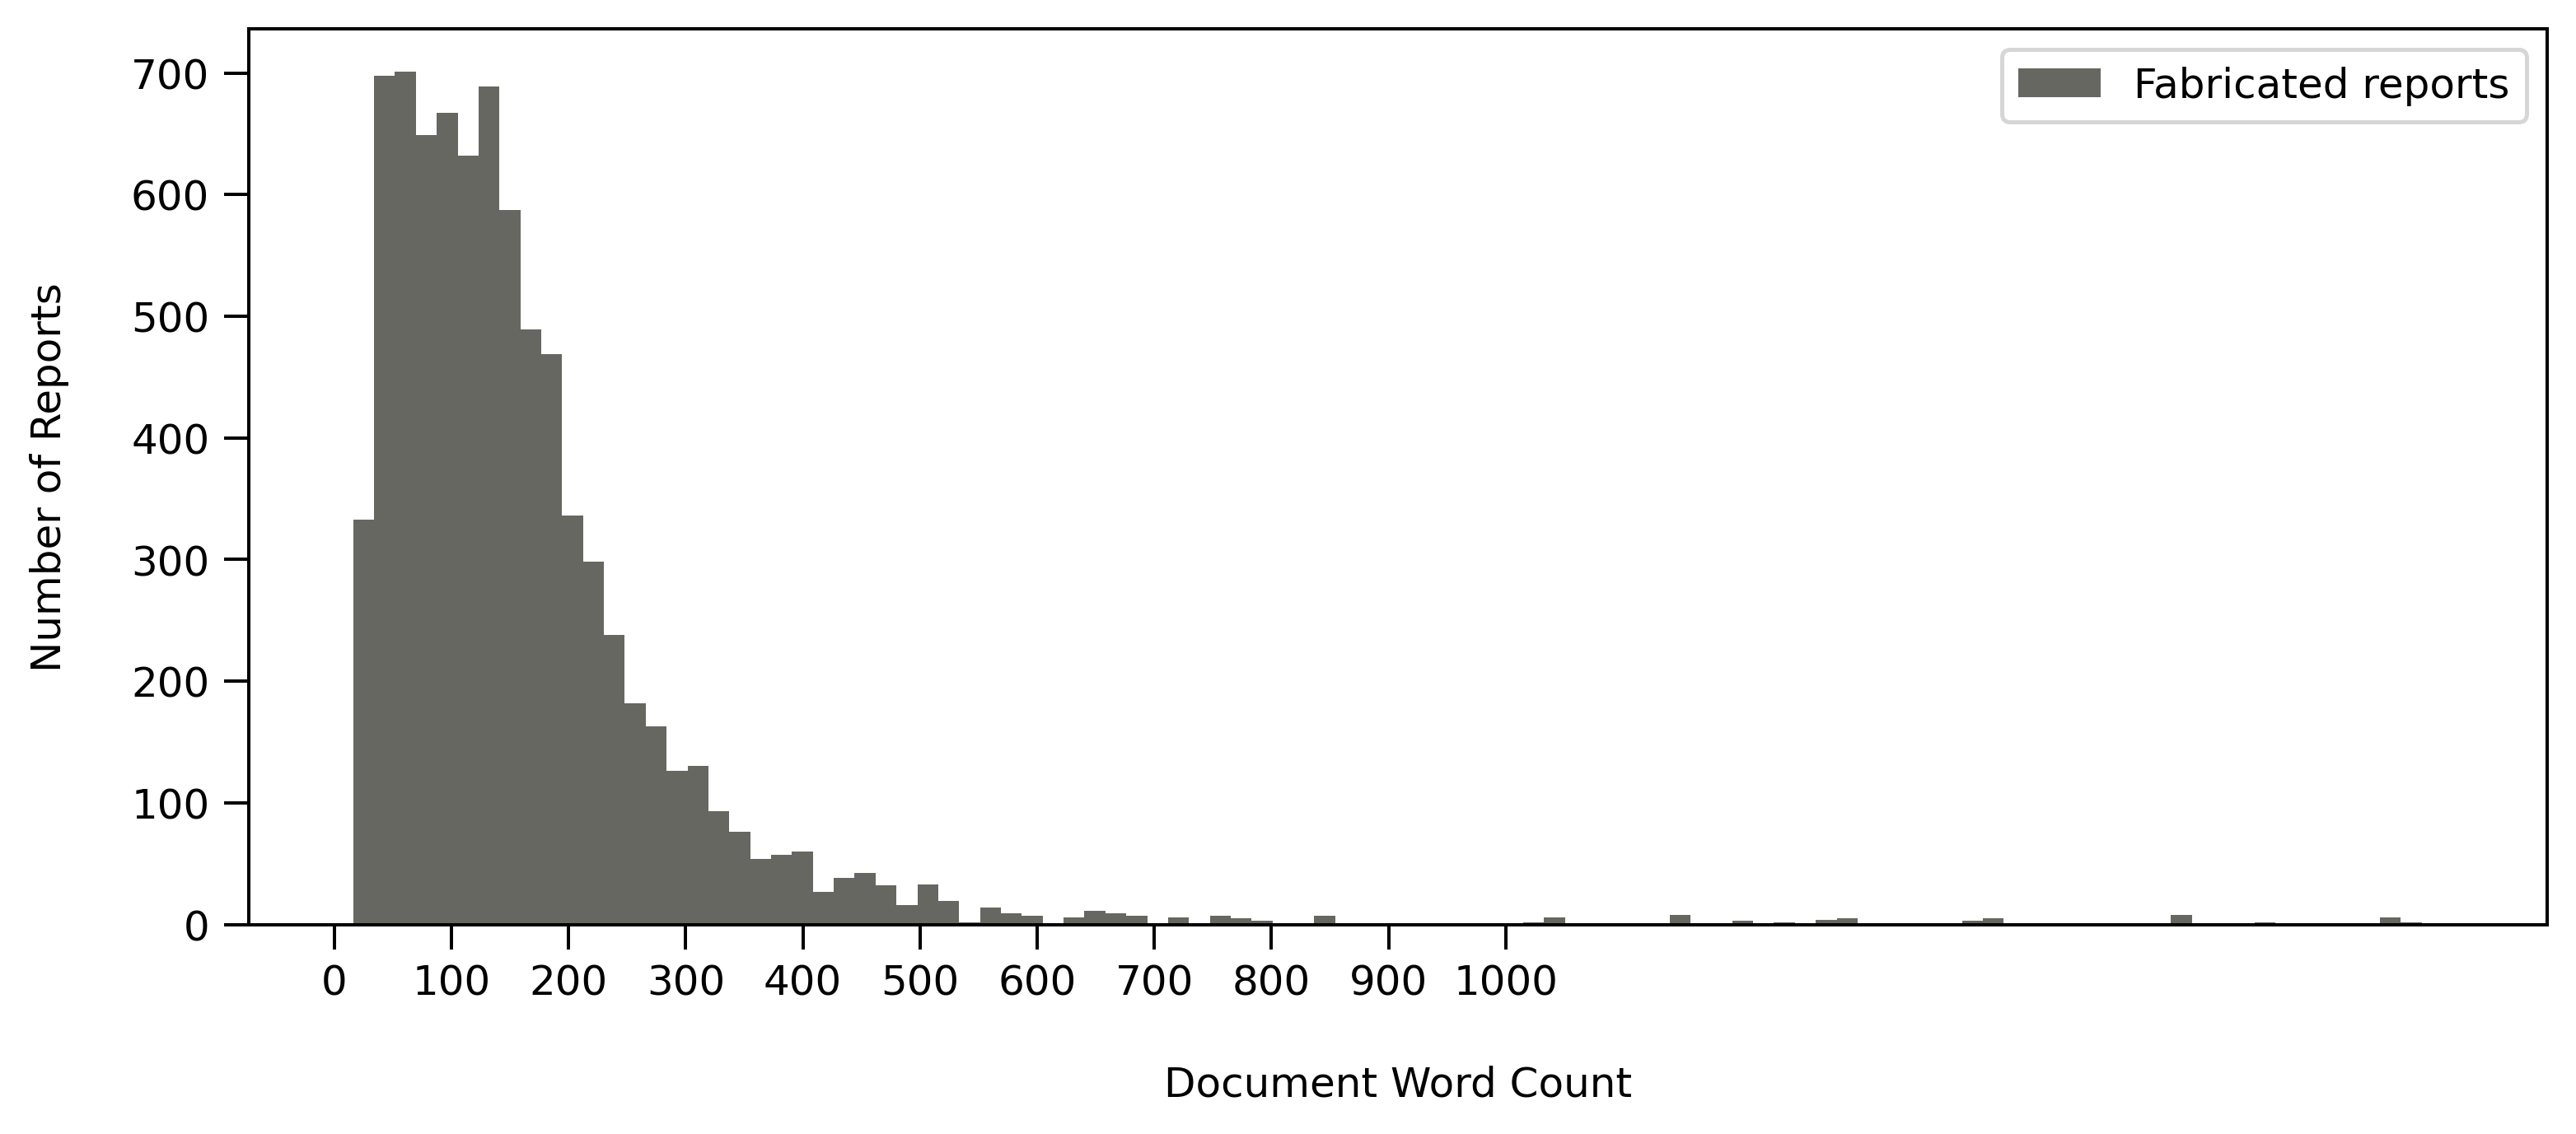

In [17]:
# Plot a histogram of word counts in the fake narratives
# Remember the real raw data has a mean word count of 62 and 95 percentile value of 309 words
# We expect to see similar distribution for the fake narratives...
doc_lens = [len(d.split()) for d in df_eda.text]
plt.figure(figsize=(10, 4), dpi=360)
plt.hist(doc_lens, bins = 100, color='#26261e', alpha=0.7, label = 'Fabricated reports')
plt.legend(loc = 'upper right')

plt.xlabel("Document Word Count", labelpad = 15)
plt.ylabel("Number of Reports", labelpad = 15)
plt.tick_params(size=6)
plt.xticks(np.linspace(0, 1000, 11))
plt.title('', fontdict=dict(size=10))
plt.show()